<a href="https://www.kaggle.com/code/cleliabernardo/notebook58766b834c?scriptVersionId=245239901" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
# critical - numpy version setup & dependencies installation

print("uninstalling existing numpy version...")
!pip uninstall numpy -y -q

print("installing numpy version 1.26.4...")
!pip install numpy==1.26.4 -q

print("\n!!! important: after this cell, restart your kernel !!!")
print("!!! (e.g., file -> restart session or kernel -> restart kernel...)")
print("!!! then, run the following cells.")

In [1]:
!pip install torch torchvision --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 361.3/363.4 MB 195.7 MB/s eta 0:00:01^C:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╸ 363.4/363.4 MB 198.9 MB/s eta 0:00:01
ERROR: Operation cancelled by user


In [ ]:
# install opencv, tensorflow, & tqdm

!pip install opencv-python --quiet
!pip install tensorflow --quiet
!pip install tqdm --quiet # for progress bars

In [40]:
!pip install mtcnn --quiet

In [41]:
# imports & gpu checks

import os
import shutil
import glob
import math
import sys
import cv2
import numpy as np
import PIL.Image
import torch
import tensorflow as tf
from mtcnn import MTCNN
from tqdm.auto import tqdm

2025-06-13 15:59:23.273508: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749830363.297369    6202 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749830363.304163    6202 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# kaggle dataset paths
input_cropped_faces_dir = '/kaggle/input/croppedfaces' # path to cropped faces dataset

# output directories for newly generated data in kaggle's writable space
kaggle_working_dir = '/kaggle/working'
output_optical_flow_dir = os.path.join(kaggle_working_dir, 'faceforensics_opticalflow_sampled_raft')
# ADD THIS LINE FOR DEPTH MAPS
output_depth_map_dir = os.path.join(kaggle_working_dir, 'faceforensics_depthmap_sampled_midas')


# create necessary output directories
os.makedirs(output_optical_flow_dir, exist_ok=True)
# ADD THIS LINE TO CREATE DEPTH MAP DIRECTORY
os.makedirs(output_depth_map_dir, exist_ok=True)


print(f"input cropped faces directory: {input_cropped_faces_dir}")
print(f"output optical flow directory: {output_optical_flow_dir}")
print(f"output depth map directory: {output_depth_map_dir}")

# tensorflow gpu check
print("\nchecking tensorflow gpu availability:")
gpu_devices_tf = tf.config.list_physical_devices('GPU')
if gpu_devices_tf:
    print(f"tensorflow found gpus: {gpu_devices_tf}")
    try:
        for gpu in gpu_devices_tf:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("tensorflow memory growth enabled.")
    except RuntimeError as e:
        print(f"couldn't set memory growth (error: {e})")
else:
    print("warning: tensorflow couldn't find a gpu. mtcnn might be slow.")

# pytorch gpu check
print("\nchecking pytorch gpu availability:")
if torch.cuda.is_available():
    device = torch.device("cuda")
    print(f"pytorch is ready to use gpu: {torch.cuda.get_device_name(0)}")
else:
    device = torch.device("cpu")
    print("warning: pytorch couldn't find a gpu. operations will be much slower.")

print(f"\npytorch will be using: {device}")

input cropped faces directory: /kaggle/input/croppedfaces
output optical flow directory: /kaggle/working/faceforensics_opticalflow_sampled_raft
output depth map directory: /kaggle/working/faceforensics_depthmap_sampled_midas

checking tensorflow gpu availability:
tensorflow found gpus: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
tensorflow memory growth enabled.

checking pytorch gpu availability:
pytorch is ready to use gpu: Tesla P100-PCIE-16GB

pytorch will be using: cuda


In [4]:
#debug

print(f"input cropped faces path: {input_cropped_faces_dir}")
print(f"output optical flow path: {output_optical_flow_dir}")

input cropped faces path: /kaggle/input/croppedfaces
output optical flow path: /kaggle/working/faceforensics_opticalflow_sampled_raft


In [ ]:
#previusly run in Colab
# extract frames from videos

# ensure tqdm is available
try:
    from tqdm.auto import tqdm
except ImportError:
    print("tqdm not found, please install with !pip install tqdm")
    tqdm = lambda x, *args, **kwargs: x # fallback to no-op if tqdm is missing

def extract_frames_from_videos(
    source_video_folder_full_path: str,
    base_dataset_root_path: str,
    base_output_folder_frames_root: str
) -> None:
    """
    extracts all frames from .mp4 videos in a source folder and saves them
    into a structured output folder, mirroring the source structure.
    skips videos if frames appear to exist already.
    """
    print(f"\nprocessing videos from: {source_video_folder_full_path}")

    video_files = glob.glob(os.path.join(source_video_folder_full_path, '*.mp4'))
    if not video_files:
        print(f"  -> no .mp4 videos found in {source_video_folder_full_path}. skipping.")
        return
    print(f"  -> found {len(video_files)} videos.")

    relative_sub_path = os.path.relpath(source_video_folder_full_path, base_dataset_root_path)

    for video_path in tqdm(video_files, desc=f"  extracting {os.path.basename(os.path.dirname(relative_sub_path))}", leave=False):
        video_name_no_ext = os.path.splitext(os.path.basename(video_path))[0]
        output_folder_for_this_video_frames = os.path.join(base_output_folder_frames_root, relative_sub_path, video_name_no_ext)

        if not os.path.exists(output_folder_for_this_video_frames):
            os.makedirs(output_folder_for_this_video_frames)
        else:
            if len(os.listdir(output_folder_for_this_video_frames)) > 0:
                continue

        cap = cv2.VideoCapture(video_path)
        frame_count = 0
        while True:
            success, frame = cap.read()
            if not success:
                break

            frame_filename = os.path.join(output_folder_for_this_video_frames, f"frame_{frame_count:05d}.png")
            cv2.imwrite(frame_filename, frame)
            frame_count += 1
        cap.release()

# non runnare

In [ ]:
#previusly run in Colab
# face detection & cropping (mtcnn) - specific frame range

from typing import Optional, List, Tuple
import time # added to fix nameerror in main block


if 'detector' not in locals() or detector is None:
    print("initializing mtcnn for face cropping...")
    try:
        detector = MTCNN() # uses tensorflow backend. will leverage gpu if available.
        print("mtcnn detector initialized successfully.")
    except Exception as e:
        print(f"fatal error during mtcnn initialization: {e}")
        detector = None
else:
    print("mtcnn detector already initialized.")

def crop_and_save_faces(
    frame_path: str,
    output_folder_for_cropped_faces: str,
    detector_instance: MTCNN,
    enlargement_factor: float = 1.3,
    min_confidence: float = 0.95
) -> int:
    """
    reads a frame, detects faces using the provided mtcnn detector,
    enlarges the bounding box, crops the faces, and saves them.
    """
    if detector_instance is None:
        return 0

    img = cv2.imread(frame_path)
    if img is None:
        return 0

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    detections = []
    try:
        detections = detector_instance.detect_faces(img_rgb)
    except Exception as e:
        # print(f"error during face detection for {frame_path}: {e}") # often due to memory issues, too verbose
        return 0

    face_saved_count = 0
    frame_basename_no_ext = os.path.splitext(os.path.basename(frame_path))[0]

    if not detections:
        return 0

    os.makedirs(output_folder_for_cropped_faces, exist_ok=True)

    for i, detection in enumerate(detections):
        if detection['confidence'] >= min_confidence:
            x, y, width, height = detection['box']
            center_x, center_y = x + width / 2, y + height / 2
            new_width, new_height = width * enlargement_factor, height * enlargement_factor
            x1, y1 = int(center_x - new_width / 2), int(center_y - new_height / 2)
            x2, y2 = int(center_x + new_width / 2), int(center_y + new_height / 2)
            x1, y1 = max(0, x1), max(0, y1)
            x2, y2 = min(img.shape[1], x2), min(img.shape[0], y2)

            if x1 >= x2 or y1 >= y2:
                continue

            face_crop = img[y1:y2, x1:x2]
            if face_crop.size > 0:
                cropped_face_filename = os.path.join(output_folder_for_cropped_faces, f"{frame_basename_no_ext}_face_{i:02d}.png")
                try:
                    cv2.imwrite(cropped_face_filename, face_crop)
                    face_saved_count += 1
                except Exception as e_write:
                    print(f"error saving cropped face {cropped_face_filename}: {e_write}")
    return face_saved_count

def process_video_frames_in_range(
    base_input_folder_frames: str,
    base_output_folder_cropped_faces: str,
    detector_instance: MTCNN,
    frame_stride: int = 7
) -> None:
    """
    recursively walks through frame folders, detects and crops faces
    from a subsample of frames (1 every 'frame_stride').
    adds new faces to existing output folders and skips frames already processed.
    """
    print(f"starting face cropping from: {base_input_folder_frames}")
    print(f"cropped faces will be saved/added to: {base_output_folder_cropped_faces}")
    print(f"processing frames with a stride of: {frame_stride} (1 frame every {frame_stride})")

    processed_video_count = 0
    grand_total_faces = 0

    video_dirs_containing_frames = []
    for root, dirs, files in os.walk(base_input_folder_frames):
        if any(f.lower().endswith('.png') for f in files):
            video_dirs_containing_frames.append(root)
    video_dirs_containing_frames.sort()

    main_pbar = tqdm(video_dirs_containing_frames, desc="scanning video dirs")

    for dirpath, _, filenames in main_pbar:
        all_frames_in_video_dir = sorted([f for f in filenames if f.lower().endswith('.png')])

        if all_frames_in_video_dir:
            video_id = os.path.basename(dirpath)
            relative_path = os.path.relpath(dirpath, base_input_folder_frames)
            output_dir_for_faces = os.path.join(base_output_folder_cropped_faces, relative_path)

            os.makedirs(output_dir_for_faces, exist_ok=True)

            faces_this_video = 0
            for i, frame_file_name in enumerate(tqdm(all_frames_in_video_dir, desc=f"  processing '{video_id}'", leave=False)):
                if i % frame_stride != 0:
                    continue

                frame_full_path = os.path.join(dirpath, frame_file_name)
                frame_basename_no_ext = os.path.splitext(os.path.basename(frame_full_path))[0]

                existing_cropped_faces = glob.glob(os.path.join(output_dir_for_faces, f"{frame_basename_no_ext}_face_*.png"))
                if existing_cropped_faces:
                    continue

                num_faces = crop_and_save_faces(frame_full_path, output_dir_for_faces, detector_instance)
                faces_this_video += num_faces

            if faces_this_video > 0:
                grand_total_faces += faces_this_video

            processed_video_count += 1
            if processed_video_count % 50 == 0:
                print(f"  -> processed {processed_video_count} videos... total new faces found: {grand_total_faces}")
    main_pbar.close()
    print(f"\nface cropping process finished.")
    print(f"videos considered for this run: {processed_video_count}.")
    print(f"total new faces saved in this run: {grand_total_faces}.")

In [45]:
# define input and output directories

# directory containing the imported dataset with cropped face frames.
INPUT_CROPPED_FACES_DIR = "/kaggle/input/croppedfaces/FaceForensics_CroppedFaces_Sampled"

# directory where optical flow (.flo) files will be saved.
OUTPUT_OPTICAL_FLOW_DIR = "/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT"
# directory where depth maps (.npy) files will be saved.
OUTPUT_DEPTH_MAP_DIR = "/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS"


print(f"Directory Input Cropped Faces: {INPUT_CROPPED_FACES_DIR}")
print(f"Directory Output Optical Flow: {OUTPUT_OPTICAL_FLOW_DIR}")
print(f"Directory Output Depth Map: {OUTPUT_DEPTH_MAP_DIR}")

Directory Input Cropped Faces: /kaggle/input/croppedfaces/FaceForensics_CroppedFaces_Sampled
Directory Output Optical Flow: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT
Directory Output Depth Map: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS


In [6]:
# raft manual setup - download and configure raft-pytorch from kagglehub

import os
import sys
import shutil
import kagglehub # import kagglehub

# aggressive cleanup (for safety)
print("cleaning up old files and directories...")
shutil.rmtree('/root/.cache/torch/hub', ignore_errors=True)
if os.path.exists('/kaggle/working/RAFT'):
    shutil.rmtree('/kaggle/working/RAFT')
shutil.rmtree('/kaggle/working/kaggle/input/daigohirooka/raft-pytorch', ignore_errors=True)
shutil.rmtree('/kaggle/working/PWC-Net', ignore_errors=True) # assuming this is also an old flow repo
print("cleanup complete.")

# change to working directory
%cd /kaggle/working/
print(f"current working directory: {os.getcwd()}")

# download raft-pytorch dataset from kagglehub
print("downloading 'daigohirooka/raft-pytorch' dataset from kagglehub...")
try:
    raft_hub_path = kagglehub.dataset_download("daigohirooka/raft-pytorch")
    print(f"raft dataset downloaded to: {raft_hub_path}")
except Exception as e:
    print(f"error downloading dataset from kagglehub: {e}")
    print("ensure you are connected to the internet and the dataset is public/accessible.")
    raise

# debug block for dataset structure
print(f"\ncontents of downloaded kagglehub directory ({raft_hub_path}):")
!ls -R {raft_hub_path} # this will recursively list subfolders
# end debug block

# the path returned by kagglehub.dataset_download is the root of the downloaded dataset.
base_path_for_sys = str(raft_hub_path)

# add the base path of the downloaded dataset to sys.path
if base_path_for_sys not in sys.path:
    sys.path.append(base_path_for_sys)
    print(f"added '{base_path_for_sys}' to sys.path to allow imports from 'raft'.")
else:
    print(f"'{base_path_for_sys}' is already in sys.path.")

print("\ncontents of sys.path after addition in part 1:")
for p in sys.path:
    print(p)

cleaning up old files and directories...
cleanup complete.
/kaggle/working
current working directory: /kaggle/working
downloading 'daigohirooka/raft-pytorch' dataset from kagglehub...
raft dataset downloaded to: /kaggle/input/raft-pytorch

contents of downloaded kagglehub directory (/kaggle/input/raft-pytorch):
/kaggle/input/raft-pytorch:
raft  raft-sintel.pth  raft-things.pth

/kaggle/input/raft-pytorch/raft:
alt_cuda_corr	  demo-frames	      LICENSE	      train.py
chairs_split.txt  demo.py	      RAFT.png	      train_standard.sh
config.py	  download_models.sh  README.md
core		  evaluate.py	      train_mixed.sh

/kaggle/input/raft-pytorch/raft/alt_cuda_corr:
correlation.cpp  correlation_kernel.cu	setup.py

/kaggle/input/raft-pytorch/raft/core:
corr.py  datasets.py  extractor.py  __init__.py  raft.py  update.py  utils

/kaggle/input/raft-pytorch/raft/core/utils:
augmentor.py  flow_viz.py  frame_utils.py  __init__.py	utils.py

/kaggle/input/raft-pytorch/raft/demo-frames:
frame_0016.png	f

In [7]:
%%writefile /kaggle/working/raft_manual_runner.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL.Image
import sys
import os
import cv2
from collections import OrderedDict

# import raft classes
from raft.core.raft import RAFT
from raft.core.utils.utils import InputPadder
from raft.config import RAFTConfig 

# define device (cpu/gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"raft will use device: {device}")

# global raft model instance
raft_model = None

# define a target image size for consistent input to raft
target_image_size = (256, 256) # (height, width)

def load_raft_model_manual():
    global raft_model
    if raft_model is None:
        print("loading raft model from kagglehub dataset...")
        try:
            model_weights_path = '/kaggle/input/raft-pytorch/raft-sintel.pth'

            if not os.path.exists(model_weights_path):
                raise FileNotFoundError(f"raft weights not found at {model_weights_path}.")

            config = RAFTConfig(
                dropout=0,
                alternate_corr=False,
                small=False,
                mixed_precision=True
            )

            raft_model = RAFT(config).to(device)

            state_dict = torch.load(model_weights_path, map_location=device)
            new_state_dict = OrderedDict()
            for key in state_dict:
                if key.startswith('module.'):
                    new_state_dict[key[len('module.') :]] = state_dict[key]
                else:
                    new_state_dict[key] = state_dict[key]
            raft_model.load_state_dict(new_state_dict)

            raft_model.eval()
            print("raft model loaded successfully from kagglehub dataset.")

        except Exception as e:
            print(f"error loading raft model: {e}")
            print("please check model configuration and weights path.")
            raise
    return raft_model

# function to estimate optical flow with raft
def estimate_optical_flow_raft(img1_tensor_cpu, img2_tensor_cpu):
    model = load_raft_model_manual()

    # raft expects images with pixel values from 0 to 255.
    image1 = img1_tensor_cpu.unsqueeze(0).to(device) * 255.0
    image2 = img2_tensor_cpu.unsqueeze(0).to(device) * 255.0

    # inputpadder adjusts dimensions to be compatible with raft's architecture.
    padder = InputPadder(image1.shape)
    image1, image2 = padder.pad(image1, image2)

    with torch.no_grad():
        flow_low, flow_up = model(image1, image2, iters=12, test_mode=True)

    return flow_up[0].cpu()

# function to save .flo file
def save_flo_file(tensor_flow, output_path):
    objOutput = open(output_path, 'wb')
    np.array([ 80, 73, 69, 72 ], np.uint8).tofile(objOutput) # magic string for .flo files
    np.array([ tensor_flow.shape[2], tensor_flow.shape[1] ], np.int32).tofile(objOutput) # width, height
    np.array(tensor_flow.numpy().transpose(1, 2, 0), np.float32).tofile(objOutput) # flow data
    objOutput.close()

# function to load images as pytorch tensors
def load_image_as_tensor(image_path):
    img = PIL.Image.open(image_path)
    img_array = np.array(img)

    # convert to rgb if grayscale or rgba
    if len(img_array.shape) == 2: # grayscale
        img_array = cv2.cvtColor(img_array, cv2.COLOR_GRAY2RGB)
    elif img_array.shape[2] == 4: # rgba
        img_array = img_array[:, :, :3] # take only rgb channels

    # resize image to a fixed size before processing
    # this ensures consistent input dimensions for raft's inputpadder
    if img_array.shape[0:2] != target_image_size:
        img_array = cv2.resize(img_array, target_image_size[::-1], interpolation=cv2.INTER_AREA)

    # convert to float32 and normalize to [0, 1]
    return torch.FloatTensor(np.ascontiguousarray(img_array.transpose(2, 0, 1)).astype(np.float32) * (1.0 / 255.0))

Writing /kaggle/working/raft_manual_runner.py


In [8]:
# optical flow generation 

import os
import glob
import time
from tqdm.notebook import tqdm
import sys
import shutil 

# import necessary functions from our manual raft runner script
if '/kaggle/working/' not in sys.path:
    sys.path.append('/kaggle/working/')

from raft_manual_runner import estimate_optical_flow_raft, save_flo_file, load_image_as_tensor

# parameter to control frame skipping
frame_skip = 5 

# base directory for your cropped face frames.
base_frames_input_dir = INPUT_CROPPED_FACES_DIR

# base directory for optical flow output (.flo files).
output_optical_flow_dir = OUTPUT_OPTICAL_FLOW_DIR

os.makedirs(output_optical_flow_dir, exist_ok=True)
print(f"optical flow (.flo) files will be saved to: {output_optical_flow_dir}")
print(f"flows will be sampled with a frame_skip of: {frame_skip}")

videos_processed_count = 0
total_new_flows = 0
overall_start_time = time.time()

# initialization
total_potential_flows_overall = 0
flows_newly_calculated_overall = 0

print(f"\nstarting optical flow generation for sampled faces in: {output_optical_flow_dir}")

video_dirs_containing_frames = []
for root, dirs, files in os.walk(base_frames_input_dir):
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
        video_dirs_containing_frames.append(root)

video_dirs_containing_frames.sort()

main_pbar = tqdm(video_dirs_containing_frames, desc="overall optical flow progress")

for dirpath_video_frames in main_pbar:
    relative_video_path = os.path.relpath(dirpath_video_frames, base_frames_input_dir)
    video_name = os.path.basename(dirpath_video_frames)
    current_video_flow_output_dir = os.path.join(output_optical_flow_dir, relative_video_path)
    os.makedirs(current_video_flow_output_dir, exist_ok=True)

    all_frame_files = sorted(glob.glob(os.path.join(dirpath_video_frames, '*.png')))

    if not all_frame_files or len(all_frame_files) < 2:
        main_pbar.write(f"  -> skipping '{video_name}': not enough cropped frames ({len(all_frame_files)}) for optical flow.")
        continue

    total_potential_flows = (len(all_frame_files) - 1) // frame_skip
    flows_newly_calculated = 0

    video_pbar = tqdm(total=total_potential_flows, desc=f"  flows for '{video_name}'", leave=False)

    for i in range(0, len(all_frame_files) - frame_skip, frame_skip):
        img1_path = all_frame_files[i]
        img2_path = all_frame_files[i + frame_skip]

        frame1_name_base = os.path.splitext(os.path.basename(img1_path))[0]
        frame2_name_base = os.path.splitext(os.path.basename(img2_path))[0]
        flow_filename = f"flow_{frame1_name_base}_to_{frame2_name_base}.flo"
        flow_output_path = os.path.join(current_video_flow_output_dir, flow_filename)

        if os.path.exists(flow_output_path):
            video_pbar.update(1)
            continue

        try:
            tenOne = load_image_as_tensor(img1_path)
            tenTwo = load_image_as_tensor(img2_path)

            tenOutput_flow = estimate_optical_flow_raft(tenOne, tenTwo)
            save_flo_file(tenOutput_flow, flow_output_path)

            flows_newly_calculated += 1
            video_pbar.update(1)

        except Exception as e:
            tqdm.write(f"    -> error during flow processing for {flow_filename} in {video_name}: {e}")
            video_pbar.update(1)

    video_pbar.close()

    if flows_newly_calculated > 0:
        main_pbar.write(f"  -> generated {flows_newly_calculated} new .flo files for '{video_name}'.")

    total_new_flows += flows_newly_calculated

main_pbar.close()

overall_end_time = time.time()
print(f"\n--- optical flow generation completed ---")
print(f"destination directory analyzed: {output_optical_flow_dir}")
print(f"total new .flo files generated in this run: {total_new_flows}")
print(f"total time taken: {(overall_end_time - overall_start_time) / 60:.2f} minutes.")

# check space after operation 
total, used, free = shutil.disk_usage("/kaggle/working/")
print(f"\ncurrent free space on /kaggle/working/: {free / (1024**3):.2f} gb")
print(f"warning: temporary .flo files are now taking up space in '{output_optical_flow_dir}'.")
print(f"proceed to cell 2 for compression.")

raft will use device: cuda
optical flow (.flo) files will be saved to: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT
flows will be sampled with a frame_skip of: 5

starting optical flow generation for sampled faces in: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT


overall optical flow progress:   0%|          | 0/347 [00:00<?, ?it/s]

  flows for '033_097':   0%|          | 0/61 [00:00<?, ?it/s]

loading raft model from kagglehub dataset...
raft model loaded successfully from kagglehub dataset.


/kaggle/input/raft-pytorch/raft/core/raft.py:99: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/kaggle/input/raft-pytorch/raft/core/raft.py:110: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):
/usr/local/lib/python3.11/dist-packages/torch/functional.py:539: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:3637.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/kaggle/input/raft-pytorch/raft/core/raft.py:127: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast(enabled=self.args.mixed_precision):


  -> generated 61 new .flo files for '033_097'.


  flows for '035_036':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '035_036'.


  flows for '036_035':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '036_035'.


  flows for '044_945':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '044_945'.


  flows for '046_904':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '046_904'.


  flows for '055_147':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '055_147'.


  flows for '062_066':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '062_066'.


  flows for '066_062':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '066_062'.


  flows for '097_033':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '097_033'.


  flows for '107_109':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '107_109'.


  flows for '109_107':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '109_107'.


  flows for '128_896':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '128_896'.


  flows for '134_192':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '134_192'.


  flows for '147_055':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '147_055'.


  flows for '150_153':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '150_153'.


  flows for '153_150':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '153_150'.


  flows for '159_175':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '159_175'.


  flows for '168_222':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 35 new .flo files for '168_222'.


  flows for '175_159':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '175_159'.


  flows for '183_253':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '183_253'.


  flows for '192_134':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 7 new .flo files for '192_134'.


  flows for '206_221':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '206_221'.


  flows for '210_241':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '210_241'.


  flows for '221_206':   0%|          | 0/34 [00:00<?, ?it/s]

  -> generated 34 new .flo files for '221_206'.


  flows for '222_168':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '222_168'.


  flows for '241_210':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '241_210'.


  flows for '252_266':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '252_266'.


  flows for '253_183':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '253_183'.


  flows for '254_261':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '254_261'.


  flows for '257_420':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 33 new .flo files for '257_420'.


  flows for '261_254':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '261_254'.


  flows for '263_284':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '263_284'.


  flows for '266_252':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '266_252'.


  flows for '272_396':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '272_396'.


  flows for '284_263':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '284_263'.


  flows for '288_321':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '288_321'.


  flows for '321_288':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '321_288'.


  flows for '337_522':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '337_522'.


  flows for '339_392':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '339_392'.


  flows for '360_437':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '360_437'.


  flows for '392_339':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 42 new .flo files for '392_339'.


  flows for '396_272':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '396_272'.


  flows for '420_257':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 40 new .flo files for '420_257'.


  flows for '434_438':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '434_438'.


  flows for '435_456':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '435_456'.


  flows for '437_360':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '437_360'.


  flows for '438_434':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '438_434'.


  flows for '439_441':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '439_441'.


  flows for '441_439':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '441_439'.


  flows for '456_435':   0%|          | 0/22 [00:00<?, ?it/s]

  -> generated 22 new .flo files for '456_435'.


  flows for '469_481':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '469_481'.


  flows for '481_469':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '481_469'.


  flows for '522_337':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 40 new .flo files for '522_337'.


  flows for '529_633':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '529_633'.


  flows for '554_572':   0%|          | 0/46 [00:00<?, ?it/s]

  -> generated 46 new .flo files for '554_572'.


  flows for '556_588':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '556_588'.


  flows for '565_589':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '565_589'.


  flows for '572_554':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '572_554'.


  flows for '585_599':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '585_599'.


  flows for '588_556':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '588_556'.


  flows for '589_565':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '589_565'.


  flows for '599_585':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '599_585'.


  flows for '607_683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '607_683'.


  flows for '633_529':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '633_529'.


  flows for '644_657':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '644_657'.


  flows for '648_654':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '648_654'.


  flows for '651_835':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '651_835'.


  flows for '654_648':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '654_648'.


  flows for '657_644':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '657_644'.


  flows for '671_677':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '671_677'.


  flows for '672_720':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '672_720'.


  flows for '677_671':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '677_671'.


  flows for '683_607':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '683_607'.


  flows for '712_716':   0%|          | 0/29 [00:00<?, ?it/s]

  -> generated 29 new .flo files for '712_716'.


  flows for '716_712':   0%|          | 0/18 [00:00<?, ?it/s]

  -> generated 18 new .flo files for '716_712'.


  flows for '720_672':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '720_672'.


  flows for '779_794':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '779_794'.


  flows for '794_779':   0%|          | 0/70 [00:00<?, ?it/s]

  -> generated 70 new .flo files for '794_779'.


  flows for '811_920':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '811_920'.


  flows for '828_830':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '828_830'.


  flows for '830_828':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '830_828'.


  flows for '835_651':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '835_651'.


  flows for '866_878':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '866_878'.


  flows for '878_866':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '878_866'.


  flows for '896_128':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '896_128'.


  flows for '897_969':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 7 new .flo files for '897_969'.


  flows for '904_046':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '904_046'.


  flows for '917_924':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '917_924'.


  flows for '920_811':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '920_811'.


  flows for '924_917':   0%|          | 0/32 [00:00<?, ?it/s]

  -> generated 32 new .flo files for '924_917'.


  flows for '942_943':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '942_943'.


  flows for '943_942':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '943_942'.


  flows for '945_044':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '945_044'.


  flows for '953_974':   0%|          | 0/39 [00:00<?, ?it/s]

  -> generated 39 new .flo files for '953_974'.


  flows for '969_897':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '969_897'.


  flows for '974_953':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '974_953'.


  flows for '980_992':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '980_992'.


  flows for '986_994':   0%|          | 0/24 [00:00<?, ?it/s]

  -> generated 24 new .flo files for '986_994'.


  flows for '992_980':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '992_980'.


  flows for '994_986':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '994_986'.


  flows for '033_097':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 33 new .flo files for '033_097'.


  flows for '035_036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '035_036'.


  flows for '036_035':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '036_035'.


  flows for '044_945':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '044_945'.


  flows for '046_904':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '046_904'.


  flows for '055_147':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '055_147'.


  flows for '062_066':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '062_066'.


  flows for '066_062':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '066_062'.


  flows for '097_033':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 23 new .flo files for '097_033'.


  flows for '107_109':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '107_109'.


  flows for '109_107':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '109_107'.


  flows for '128_896':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '128_896'.


  flows for '134_192':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 7 new .flo files for '134_192'.


  flows for '147_055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '147_055'.


  flows for '150_153':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '150_153'.


  flows for '153_150':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '153_150'.


  flows for '159_175':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '159_175'.


  flows for '168_222':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '168_222'.


  flows for '175_159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '175_159'.


  flows for '183_253':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '183_253'.


  flows for '192_134':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '192_134'.


  flows for '206_221':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '206_221'.


  flows for '210_241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '210_241'.


  flows for '221_206':   0%|          | 0/38 [00:00<?, ?it/s]

  -> generated 38 new .flo files for '221_206'.


  flows for '222_168':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 35 new .flo files for '222_168'.


  flows for '241_210':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 23 new .flo files for '241_210'.


  flows for '252_266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '252_266'.


  flows for '253_183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '253_183'.


  flows for '254_261':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '254_261'.


  flows for '257_420':   0%|          | 0/56 [00:00<?, ?it/s]

  -> generated 56 new .flo files for '257_420'.


  flows for '261_254':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '261_254'.


  flows for '263_284':   0%|          | 0/22 [00:00<?, ?it/s]

  -> generated 22 new .flo files for '263_284'.


  flows for '266_252':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '266_252'.


  flows for '272_396':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '272_396'.


  flows for '284_263':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '284_263'.


  flows for '288_321':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '288_321'.


  flows for '321_288':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '321_288'.


  flows for '337_522':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '337_522'.


  flows for '339_392':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 42 new .flo files for '339_392'.


  flows for '360_437':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '360_437'.


  flows for '392_339':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '392_339'.


  flows for '396_272':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '396_272'.


  flows for '420_257':   0%|          | 0/27 [00:00<?, ?it/s]

  -> generated 27 new .flo files for '420_257'.


  flows for '434_438':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '434_438'.


  flows for '435_456':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 17 new .flo files for '435_456'.


  flows for '437_360':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '437_360'.


  flows for '438_434':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '438_434'.


  flows for '439_441':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '439_441'.


  flows for '441_439':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '441_439'.


  flows for '456_435':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 17 new .flo files for '456_435'.


  flows for '469_481':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '469_481'.


  flows for '481_469':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '481_469'.


  flows for '522_337':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '522_337'.


  flows for '529_633':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '529_633'.


  flows for '554_572':   0%|          | 0/18 [00:00<?, ?it/s]

  -> generated 18 new .flo files for '554_572'.


  flows for '556_588':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '556_588'.


  flows for '565_589':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '565_589'.


  flows for '572_554':   0%|          | 0/25 [00:00<?, ?it/s]

  -> generated 25 new .flo files for '572_554'.


  flows for '585_599':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '585_599'.


  flows for '588_556':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '588_556'.


  flows for '589_565':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '589_565'.


  flows for '599_585':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '599_585'.


  flows for '607_683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '607_683'.


  flows for '633_529':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '633_529'.


  flows for '644_657':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '644_657'.


  flows for '648_654':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '648_654'.


  flows for '651_835':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '651_835'.


  flows for '654_648':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '654_648'.


  flows for '657_644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '657_644'.


  flows for '671_677':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '671_677'.


  flows for '672_720':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '672_720'.


  flows for '677_671':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '677_671'.


  flows for '683_607':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '683_607'.


  flows for '712_716':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 33 new .flo files for '712_716'.


  flows for '716_712':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '716_712'.


  flows for '720_672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '720_672'.


  flows for '779_794':   0%|          | 0/25 [00:00<?, ?it/s]

  -> generated 25 new .flo files for '779_794'.


  flows for '794_779':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '794_779'.


  flows for '811_920':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '811_920'.


  flows for '828_830':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '828_830'.


  flows for '830_828':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 7 new .flo files for '830_828'.


  flows for '835_651':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '835_651'.


  flows for '866_878':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '866_878'.


  flows for '878_866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '878_866'.


  flows for '896_128':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '896_128'.


  flows for '897_969':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '897_969'.


  flows for '904_046':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '904_046'.


  flows for '917_924':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 35 new .flo files for '917_924'.


  flows for '920_811':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '920_811'.


  flows for '924_917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '924_917'.


  flows for '942_943':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '942_943'.


  flows for '943_942':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '943_942'.


  flows for '945_044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '945_044'.


  flows for '953_974':   0%|          | 0/29 [00:00<?, ?it/s]

  -> generated 29 new .flo files for '953_974'.


  flows for '969_897':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '969_897'.


  flows for '974_953':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '974_953'.


  flows for '980_992':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '980_992'.


  flows for '986_994':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '986_994'.


  flows for '992_980':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '992_980'.


  flows for '994_986':   0%|          | 0/43 [00:00<?, ?it/s]

  -> generated 43 new .flo files for '994_986'.


  flows for '033_097':   0%|          | 0/32 [00:00<?, ?it/s]

  -> generated 32 new .flo files for '033_097'.


  flows for '035_036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '035_036'.


  flows for '036_035':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '036_035'.


  flows for '044_945':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '044_945'.


  flows for '055_147':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '055_147'.


  flows for '097_033':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '097_033'.


  flows for '134_192':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '134_192'.


  flows for '147_055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '147_055'.


  flows for '159_175':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '159_175'.


  flows for '175_159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '175_159'.


  flows for '183_253':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '183_253'.


  flows for '192_134':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 7 new .flo files for '192_134'.


  flows for '210_241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '210_241'.


  flows for '241_210':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '241_210'.


  flows for '252_266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '252_266'.


  flows for '253_183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '253_183'.


  flows for '263_284':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '263_284'.


  flows for '266_252':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '266_252'.


  flows for '272_396':   0%|          | 0/2 [00:00<?, ?it/s]

  -> generated 2 new .flo files for '272_396'.


  flows for '284_263':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '284_263'.


  flows for '339_392':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '339_392'.


  flows for '392_339':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '392_339'.


  flows for '469_481':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '469_481'.


  flows for '481_469':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '481_469'.


  flows for '585_599':   0%|          | 0/18 [00:00<?, ?it/s]

  -> generated 18 new .flo files for '585_599'.


  flows for '599_585':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '599_585'.


  flows for '644_657':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '644_657'.


  flows for '648_654':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '648_654'.


  flows for '654_648':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '654_648'.


  flows for '657_644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '657_644'.


  flows for '672_720':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '672_720'.


  flows for '712_716':   0%|          | 0/28 [00:00<?, ?it/s]

  -> generated 28 new .flo files for '712_716'.


  flows for '716_712':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '716_712'.


  flows for '720_672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '720_672'.


  flows for '828_830':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '828_830'.


  flows for '830_828':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '830_828'.


  flows for '866_878':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '866_878'.


  flows for '878_866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '878_866'.


  flows for '917_924':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '917_924'.


  flows for '924_917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '924_917'.


  flows for '942_943':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '942_943'.


  flows for '943_942':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '943_942'.


  flows for '945_044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '945_044'.


  flows for '980_992':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '980_992'.


  flows for '986_994':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '986_994'.


  flows for '992_980':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '992_980'.


  flows for '994_986':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '994_986'.


  flows for '033':   0%|          | 0/61 [00:00<?, ?it/s]

  -> generated 61 new .flo files for '033'.


  flows for '035':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '035'.


  flows for '036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '036'.


  flows for '044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '044'.


  flows for '046':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '046'.


  flows for '055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '055'.


  flows for '062':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '062'.


  flows for '066':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '066'.


  flows for '097':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '097'.


  flows for '107':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '107'.


  flows for '109':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '109'.


  flows for '128':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '128'.


  flows for '134':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '134'.


  flows for '147':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '147'.


  flows for '150':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '150'.


  flows for '153':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '153'.


  flows for '159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '159'.


  flows for '168':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 35 new .flo files for '168'.


  flows for '175':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '175'.


  flows for '183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '183'.


  flows for '192':   0%|          | 0/6 [00:00<?, ?it/s]

  -> generated 6 new .flo files for '192'.


  flows for '206':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '206'.


  flows for '210':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 23 new .flo files for '210'.


  flows for '221':   0%|          | 0/39 [00:00<?, ?it/s]

  -> generated 39 new .flo files for '221'.


  flows for '222':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '222'.


  flows for '241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '241'.


  flows for '252':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '252'.


  flows for '253':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '253'.


  flows for '254':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '254'.


  flows for '257':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 33 new .flo files for '257'.


  flows for '261':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '261'.


  flows for '263':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '263'.


  flows for '266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '266'.


  flows for '272':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '272'.


  flows for '284':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '284'.


  flows for '288':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '288'.


  flows for '321':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '321'.


  flows for '337':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '337'.


  flows for '339':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '339'.


  flows for '360':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '360'.


  flows for '392':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 42 new .flo files for '392'.


  flows for '396':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '396'.


  flows for '420':   0%|          | 0/44 [00:00<?, ?it/s]

  -> generated 44 new .flo files for '420'.


  flows for '434':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '434'.


  flows for '435':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '435'.


  flows for '437':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '437'.


  flows for '438':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '438'.


  flows for '439':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '439'.


  flows for '441':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '441'.


  flows for '456':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 23 new .flo files for '456'.


  flows for '469':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '469'.


  flows for '481':   0%|          | 0/6 [00:00<?, ?it/s]

  -> generated 6 new .flo files for '481'.


  flows for '522':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 40 new .flo files for '522'.


  flows for '529':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '529'.


  flows for '554':   0%|          | 0/44 [00:00<?, ?it/s]

  -> generated 44 new .flo files for '554'.


  flows for '556':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '556'.


  flows for '565':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '565'.


  flows for '572':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '572'.


  flows for '585':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '585'.


  flows for '588':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '588'.


  flows for '589':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 19 new .flo files for '589'.


  flows for '599':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '599'.


  flows for '607':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '607'.


  flows for '633':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '633'.


  flows for '644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '644'.


  flows for '648':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 17 new .flo files for '648'.


  flows for '651':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '651'.


  flows for '654':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '654'.


  flows for '657':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '657'.


  flows for '671':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '671'.


  flows for '672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '672'.


  flows for '677':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '677'.


  flows for '683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '683'.


  flows for '712':   0%|          | 0/29 [00:00<?, ?it/s]

  -> generated 29 new .flo files for '712'.


  flows for '716':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 17 new .flo files for '716'.


  flows for '720':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '720'.


  flows for '779':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '779'.


  flows for '794':   0%|          | 0/68 [00:00<?, ?it/s]

  -> generated 68 new .flo files for '794'.


  flows for '811':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '811'.


  flows for '828':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '828'.


  flows for '830':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 11 new .flo files for '830'.


  flows for '835':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '835'.


  flows for '866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 14 new .flo files for '866'.


  flows for '878':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 21 new .flo files for '878'.


  flows for '896':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 15 new .flo files for '896'.


  flows for '897':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 8 new .flo files for '897'.


  flows for '904':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '904'.


  flows for '917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 12 new .flo files for '917'.


  flows for '920':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '920'.


  flows for '924':   0%|          | 0/30 [00:00<?, ?it/s]

  -> generated 30 new .flo files for '924'.


  flows for '942':   0%|          | 0/5 [00:00<?, ?it/s]

  -> generated 5 new .flo files for '942'.


  flows for '943':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 13 new .flo files for '943'.


  flows for '945':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '945'.


  flows for '953':   0%|          | 0/38 [00:00<?, ?it/s]

  -> generated 38 new .flo files for '953'.


  flows for '969':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '969'.


  flows for '974':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 9 new .flo files for '974'.


  flows for '980':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 10 new .flo files for '980'.


  flows for '986':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 23 new .flo files for '986'.


  flows for '992':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 20 new .flo files for '992'.


  flows for '994':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 16 new .flo files for '994'.

--- optical flow generation completed ---
destination directory analyzed: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT
total new .flo files generated in this run: 5435
total time taken: 7.31 minutes.

current free space on /kaggle/working/: 16.83 gb
proceed to cell 2 for compression.


Ricerca del 7° flusso ottico per il video '035' nella compressione 'c23' in: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT

Visualizzazione di 4 flussi selezionati per il video '035':


Generazione immagini di flusso:   0%|          | 0/4 [00:00<?, ?it/s]

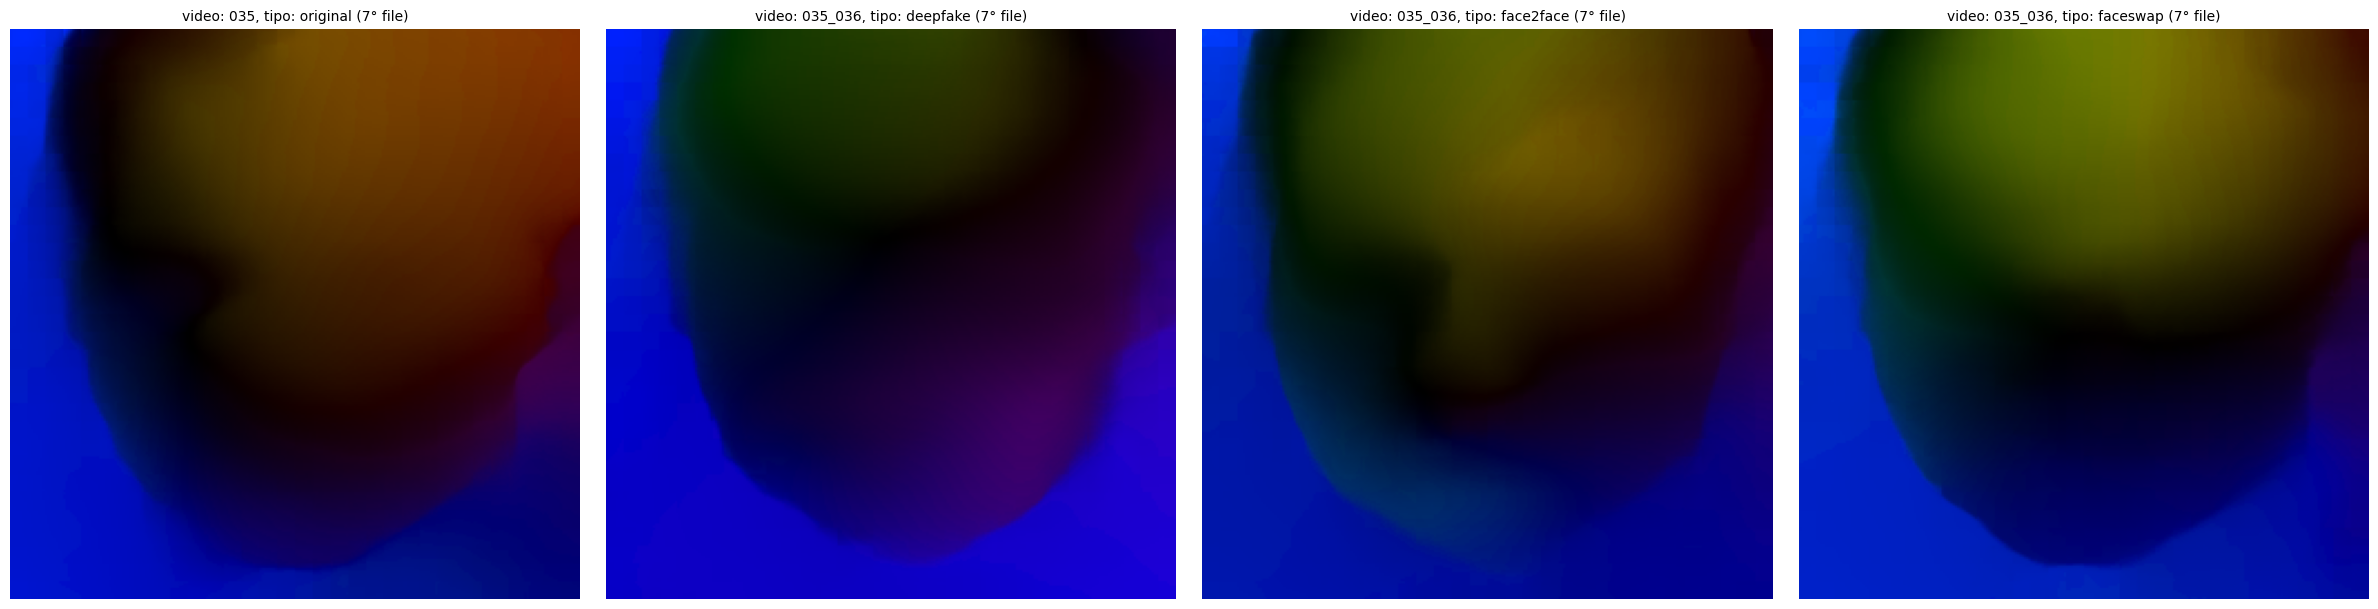


Visualizzazione del flusso completata.


In [130]:
# visualize optical flow - changed for video 035 and 10th file

import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import random # not used here, but good to have
import glob # for finding files

def load_flo_file(filepath):
    """loads a .flo file."""
    with open(filepath, 'rb') as f:
        tag = np.fromfile(f, np.float32, count=1)[0]
        if tag != 202021.25: raise Exception('bad .flo file tag!')
        width = np.fromfile(f, np.int32, count=1)[0]
        height = np.fromfile(f, np.int32, count=1)[0]
        data = np.fromfile(f, np.float32, count=height * width * 2)
    flow = np.reshape(data, (height, width, 2))
    return flow

def flow_to_image(flow):
    """converts optical flow to a colorful rgb image."""
    # make flow values ready for visualization (magnitude and angle)
    hsv = np.zeros((flow.shape[0], flow.shape[1], 3), dtype=np.uint8)
    mag, ang = cv2.cartToPolar(flow[..., 0], flow[..., 1])
    hsv[..., 0] = ang * 180 / np.pi / 2
    hsv[..., 1] = 255
    hsv[..., 2] = cv2.normalize(mag, None, 0, 255, cv2.NORM_MINMAX) # scale magnitude to 0-255
    rgb = cv2.cvtColor(hsv, cv2.COLOR_HSV2BGR)
    return rgb

# --- visualization setup ---

# where the .flo files are
flo_input_dir = OUTPUT_OPTICAL_FLOW_DIR

# the specific video we care about
target_video_id_prefix = '035'

# the compression folder 
target_compression_folder = 'c23'

# map of manipulation type to its full folder path and display name.
manipulation_types_map = {
    'original': ('original_sequences/youtube', 'original'),
    'deepfake': ('manipulated_sequences/Deepfakes', 'deepfake'),
    'face2face': ('manipulated_sequences/Face2Face', 'face2face'),
    'faceswap': ('manipulated_sequences/FaceSwap', 'faceswap')
}
ordered_manipulation_keys = ['original', 'deepfake', 'face2face', 'faceswap'] # keeps display order consistent

flows_to_display = []
titles_to_display = []
file_index_to_pick = 6 

print(f"looking for the {file_index_to_pick + 1}th optical flow file for video '{target_video_id_prefix}' in compression '{target_compression_folder}' at: {flo_input_dir}")

for manip_key in ordered_manipulation_keys:
    folder_path_component, display_name = manipulation_types_map[manip_key]
    
    # build the base path to video id folders
    base_video_id_search_path = os.path.join(flo_input_dir, folder_path_component, target_compression_folder, 'videos')
    
    # find specific video folders that start with target_video_id_prefix
    potential_video_id_dirs = glob.glob(os.path.join(base_video_id_search_path, f"{target_video_id_prefix}*"))
    
    selected_video_id_dir = None
    actual_video_id = ""

    if potential_video_id_dirs:
        selected_video_id_dir = sorted(potential_video_id_dirs)[0] 
        actual_video_id = os.path.basename(selected_video_id_dir) # get the exact video id (e.g., '035_097')
    else:
        print(f"  -> warning: no video id folders starting with '{target_video_id_prefix}' found for '{display_name}' in '{base_video_id_search_path}'. skipping.")
        flows_to_display.append(None)
        titles_to_display.append(f"n/a: {display_name} (video {target_video_id_prefix} not found)")
        continue # move to the next manipulation type

    # find all .flo files inside the chosen video id directory
    all_flo_files_in_dir = sorted(glob.glob(os.path.join(selected_video_id_dir, '*.flo')))
    
    if len(all_flo_files_in_dir) > file_index_to_pick:
        # select the 10th .flo file (index 9)
        selected_flo_path = all_flo_files_in_dir[file_index_to_pick]
        flows_to_display.append(selected_flo_path)
        titles_to_display.append(f"video: {actual_video_id}, type: {display_name} ({file_index_to_pick + 1}th file)")
    else:
        print(f"  -> warning: found only {len(all_flo_files_in_dir)} .flo files for video '{actual_video_id}' ({display_name}) in '{selected_video_id_dir}'. the {file_index_to_pick + 1}th file isn't there. skipping.")
        flows_to_display.append(None)
        titles_to_display.append(f"n/a: {actual_video_id} ({display_name}) (not available)")


if not flows_to_display or all(f is None for f in flows_to_display):
    print(f"\nno .flo files available for video '{target_video_id_prefix}' and compression '{target_compression_folder}' across the chosen categories. check video id, file index, and directory structure.")
else:
    print(f"\ndisplaying {len(flows_to_display)} selected flows for video '{target_video_id_prefix}':")

    # set figure size based on how many flows to show
    num_rows = 1
    num_cols = len(ordered_manipulation_keys) 
    
    plt.figure(figsize=(num_cols * 6, 6))
    plt.subplots_adjust(wspace=0.3, hspace=0.3)

    for i, flo_path in enumerate(tqdm(flows_to_display, desc="generating flow images")):
        plt.subplot(num_rows, num_cols, i + 1)
        if flo_path:
            try:
                flow_data = load_flo_file(flo_path)
                flow_image = flow_to_image(flow_data)
                
                plt.imshow(flow_image)
                plt.title(titles_to_display[i], fontsize=10)
                plt.axis('off')
            except Exception as e:
                plt.text(0.5, 0.5, f"loading error: {os.path.basename(flo_path)}\n{e}",
                         horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8)
                plt.title(titles_to_display[i] + " (error)", fontsize=10)
                plt.axis('off')
        else:
            plt.text(0.5, 0.5, "flow not found", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, fontsize=8)
            plt.title(titles_to_display[i] + " (missing)", fontsize=10)
            plt.axis('off')

    plt.tight_layout()
    plt.show()

print("\nflow visualization completed.")

In [14]:
# depth map generation

import os
import glob
import time
from tqdm.notebook import tqdm
import sys
import shutil

# import necessary functions from our manual depth runner script
if '/kaggle/working/' not in sys.path:
    sys.path.append('/kaggle/working/')

from depth_manual_runner import estimate_depth_midas, save_depth_map_npy

# parameter to control frame skipping (use same as optical flow for consistency)
frame_skip = 5 

# base directory for your cropped face frames.
base_frames_input_dir = INPUT_CROPPED_FACES_DIR

# base directory for depth map output (.npy files).
output_depth_map_dir = OUTPUT_DEPTH_MAP_DIR

os.makedirs(output_depth_map_dir, exist_ok=True)
print(f"depth map (.npy) files will be saved to: {output_depth_map_dir}")
print(f"depth maps will be sampled with a frame_skip of: {frame_skip}")

videos_processed_count_depth = 0
total_new_depth_maps = 0
overall_start_time_depth = time.time()

print(f"\nstarting depth map generation for sampled faces in: {output_depth_map_dir}")

# initialize an empty list
video_dirs_containing_frames_depth = []
for root, dirs, files in os.walk(base_frames_input_dir):
    if any(f.lower().endswith(('.png', '.jpg', '.jpeg')) for f in files):
        video_dirs_containing_frames_depth.append(root)

video_dirs_containing_frames_depth.sort()

main_pbar_depth = tqdm(video_dirs_containing_frames_depth, desc="overall depth map progress")

for dirpath_video_frames in main_pbar_depth:
    relative_video_path = os.path.relpath(dirpath_video_frames, base_frames_input_dir)
    video_name = os.path.basename(dirpath_video_frames)
    current_video_depth_output_dir = os.path.join(output_depth_map_dir, relative_video_path)
    os.makedirs(current_video_depth_output_dir, exist_ok=True)

    all_frame_files = sorted(glob.glob(os.path.join(dirpath_video_frames, '*.png')))

    if not all_frame_files:
        main_pbar_depth.write(f"  -> skipping '{video_name}': no cropped frames found for depth map generation.")
        continue

    total_potential_depth_maps = len(all_frame_files) // frame_skip 
    if total_potential_depth_maps == 0 and len(all_frame_files) > 0: 
        total_potential_depth_maps = 1

    depth_pbar = tqdm(total=total_potential_depth_maps, desc=f"  depths for '{video_name}'", leave=False)

    # generate depth map for the first frame of each optical flow pair
    for i in range(0, len(all_frame_files), frame_skip):
        img_path = all_frame_files[i]
        
        frame_name_base = os.path.splitext(os.path.basename(img_path))[0] 
        depth_filename = f"depth_{frame_name_base}.npy" 
        depth_output_path = os.path.join(current_video_depth_output_dir, depth_filename)

        if os.path.exists(depth_output_path):
            depth_pbar.update(1)
            continue

        try:
            depth_map_np = estimate_depth_midas(img_path)
            save_depth_map_npy(depth_map_np, depth_output_path)

            total_new_depth_maps += 1
            depth_pbar.update(1)

        except Exception as e:
            tqdm.write(f"    -> error during depth processing for {depth_filename} in {video_name}: {e}")
            depth_pbar.update(1)

    depth_pbar.close()

    if total_new_depth_maps > 0:
        main_pbar_depth.write(f"  -> generated {total_new_depth_maps} new.npy depth maps for '{video_name}'.")

main_pbar_depth.close()

overall_end_time_depth = time.time()
print(f"\n--- depth map generation completed ---")
print(f"destination directory analyzed: {output_depth_map_dir}")
print(f"total new.npy depth maps generated in this run: {total_new_depth_maps}")
print(f"total time taken: {(overall_end_time_depth - overall_start_time_depth) / 60:.2f} minutes.")

total, used, free = shutil.disk_usage("/kaggle/working/")
print(f"\ncurrent free space on /kaggle/working/: {free / (1024**3):.2f} GB")
print(f"warning: temporary.npy depth maps are now taking up space in '{output_depth_map_dir}'.")

MiDaS will use device: cuda
depth map (.npy) files will be saved to: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS
depth maps will be sampled with a frame_skip of: 5

starting depth map generation for sampled faces in: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS


overall depth map progress:   0%|          | 0/347 [00:00<?, ?it/s]

  depths for '033_097':   0%|          | 0/61 [00:00<?, ?it/s]

loading MiDaS model from torch.hub...


/usr/local/lib/python3.11/dist-packages/torch/hub.py:330: UserWarning: You are about to download and run code from an untrusted repository. In a future release, this won't be allowed. To add the repository to your trusted list, change the command to {calling_fn}(..., trust_repo=False) and a command prompt will appear asking for an explicit confirmation of trust, or load(..., trust_repo=True), which will assume that the prompt is to be answered with 'yes'. You can also use load(..., trust_repo='check') which will only prompt for confirmation if the repo is not already trusted. This will eventually be the default behaviour
  warnings.warn(
Downloading: "https://github.com/intel-isl/MiDaS/zipball/master" to /root/.cache/torch/hub/master.zip
/usr/local/lib/python3.11/dist-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.l

MiDaS model loaded successfully from torch.hub.
  -> generated 62 new.npy depth maps for '033_097'.


  depths for '035_036':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 75 new.npy depth maps for '035_036'.


  depths for '036_035':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 85 new.npy depth maps for '036_035'.


  depths for '044_945':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 95 new.npy depth maps for '044_945'.


  depths for '046_904':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 109 new.npy depth maps for '046_904'.


  depths for '055_147':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 121 new.npy depth maps for '055_147'.


  depths for '062_066':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 134 new.npy depth maps for '062_066'.


  depths for '066_062':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 148 new.npy depth maps for '066_062'.


  depths for '097_033':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 162 new.npy depth maps for '097_033'.


  depths for '107_109':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 178 new.npy depth maps for '107_109'.


  depths for '109_107':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 187 new.npy depth maps for '109_107'.


  depths for '128_896':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 208 new.npy depth maps for '128_896'.


  depths for '134_192':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 218 new.npy depth maps for '134_192'.


  depths for '147_055':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 238 new.npy depth maps for '147_055'.


  depths for '150_153':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 252 new.npy depth maps for '150_153'.


  depths for '153_150':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 273 new.npy depth maps for '153_150'.


  depths for '159_175':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 283 new.npy depth maps for '159_175'.


  depths for '168_222':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 319 new.npy depth maps for '168_222'.


  depths for '175_159':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 334 new.npy depth maps for '175_159'.


  depths for '183_253':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 346 new.npy depth maps for '183_253'.


  depths for '192_134':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 354 new.npy depth maps for '192_134'.


  depths for '206_221':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 375 new.npy depth maps for '206_221'.


  depths for '210_241':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 396 new.npy depth maps for '210_241'.


  depths for '221_206':   0%|          | 0/34 [00:00<?, ?it/s]

  -> generated 431 new.npy depth maps for '221_206'.


  depths for '222_168':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 443 new.npy depth maps for '222_168'.


  depths for '241_210':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 452 new.npy depth maps for '241_210'.


  depths for '252_266':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 469 new.npy depth maps for '252_266'.


  depths for '253_183':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 484 new.npy depth maps for '253_183'.


  depths for '254_261':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 497 new.npy depth maps for '254_261'.


  depths for '257_420':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 531 new.npy depth maps for '257_420'.


  depths for '261_254':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 551 new.npy depth maps for '261_254'.


  depths for '263_284':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 566 new.npy depth maps for '263_284'.


  depths for '266_252':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 580 new.npy depth maps for '266_252'.


  depths for '272_396':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 590 new.npy depth maps for '272_396'.


  depths for '284_263':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 604 new.npy depth maps for '284_263'.


  depths for '288_321':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 620 new.npy depth maps for '288_321'.


  depths for '321_288':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 635 new.npy depth maps for '321_288'.


  depths for '337_522':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 645 new.npy depth maps for '337_522'.


  depths for '339_392':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 658 new.npy depth maps for '339_392'.


  depths for '360_437':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 669 new.npy depth maps for '360_437'.


  depths for '392_339':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 712 new.npy depth maps for '392_339'.


  depths for '396_272':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 727 new.npy depth maps for '396_272'.


  depths for '420_257':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 768 new.npy depth maps for '420_257'.


  depths for '434_438':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 778 new.npy depth maps for '434_438'.


  depths for '435_456':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 792 new.npy depth maps for '435_456'.


  depths for '437_360':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 809 new.npy depth maps for '437_360'.


  depths for '438_434':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 825 new.npy depth maps for '438_434'.


  depths for '439_441':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 839 new.npy depth maps for '439_441'.


  depths for '441_439':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 848 new.npy depth maps for '441_439'.


  depths for '456_435':   0%|          | 0/22 [00:00<?, ?it/s]

  -> generated 871 new.npy depth maps for '456_435'.


  depths for '469_481':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 880 new.npy depth maps for '469_481'.


  depths for '481_469':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 893 new.npy depth maps for '481_469'.


  depths for '522_337':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 934 new.npy depth maps for '522_337'.


  depths for '529_633':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 944 new.npy depth maps for '529_633'.


  depths for '554_572':   0%|          | 0/47 [00:00<?, ?it/s]

  -> generated 991 new.npy depth maps for '554_572'.


  depths for '556_588':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1002 new.npy depth maps for '556_588'.


  depths for '565_589':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 1015 new.npy depth maps for '565_589'.


  depths for '572_554':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1026 new.npy depth maps for '572_554'.


  depths for '585_599':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 1046 new.npy depth maps for '585_599'.


  depths for '588_556':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1062 new.npy depth maps for '588_556'.


  depths for '589_565':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 1082 new.npy depth maps for '589_565'.


  depths for '599_585':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 1094 new.npy depth maps for '599_585'.


  depths for '607_683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 1103 new.npy depth maps for '607_683'.


  depths for '633_529':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 1112 new.npy depth maps for '633_529'.


  depths for '644_657':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 1124 new.npy depth maps for '644_657'.


  depths for '648_654':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 1141 new.npy depth maps for '648_654'.


  depths for '651_835':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1152 new.npy depth maps for '651_835'.


  depths for '654_648':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 1164 new.npy depth maps for '654_648'.


  depths for '657_644':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1180 new.npy depth maps for '657_644'.


  depths for '671_677':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1190 new.npy depth maps for '671_677'.


  depths for '672_720':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1206 new.npy depth maps for '672_720'.


  depths for '677_671':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1215 new.npy depth maps for '677_671'.


  depths for '683_607':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 1224 new.npy depth maps for '683_607'.


  depths for '712_716':   0%|          | 0/29 [00:00<?, ?it/s]

  -> generated 1254 new.npy depth maps for '712_716'.


  depths for '716_712':   0%|          | 0/18 [00:00<?, ?it/s]

  -> generated 1273 new.npy depth maps for '716_712'.


  depths for '720_672':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 1290 new.npy depth maps for '720_672'.


  depths for '779_794':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1300 new.npy depth maps for '779_794'.


  depths for '794_779':   0%|          | 0/71 [00:00<?, ?it/s]

  -> generated 1371 new.npy depth maps for '794_779'.


  depths for '811_920':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1387 new.npy depth maps for '811_920'.


  depths for '828_830':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1397 new.npy depth maps for '828_830'.


  depths for '830_828':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 1412 new.npy depth maps for '830_828'.


  depths for '835_651':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 1425 new.npy depth maps for '835_651'.


  depths for '866_878':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 1440 new.npy depth maps for '866_878'.


  depths for '878_866':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 1462 new.npy depth maps for '878_866'.


  depths for '896_128':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1478 new.npy depth maps for '896_128'.


  depths for '897_969':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 1486 new.npy depth maps for '897_969'.


  depths for '904_046':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1497 new.npy depth maps for '904_046'.


  depths for '917_924':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 1510 new.npy depth maps for '917_924'.


  depths for '920_811':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1521 new.npy depth maps for '920_811'.


  depths for '924_917':   0%|          | 0/32 [00:00<?, ?it/s]

  -> generated 1554 new.npy depth maps for '924_917'.


  depths for '942_943':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 1569 new.npy depth maps for '942_943'.


  depths for '943_942':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 1583 new.npy depth maps for '943_942'.


  depths for '945_044':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 1605 new.npy depth maps for '945_044'.


  depths for '953_974':   0%|          | 0/39 [00:00<?, ?it/s]

  -> generated 1645 new.npy depth maps for '953_974'.


  depths for '969_897':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1656 new.npy depth maps for '969_897'.


  depths for '974_953':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1666 new.npy depth maps for '974_953'.


  depths for '980_992':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 1677 new.npy depth maps for '980_992'.


  depths for '986_994':   0%|          | 0/24 [00:00<?, ?it/s]

  -> generated 1702 new.npy depth maps for '986_994'.


  depths for '992_980':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 1722 new.npy depth maps for '992_980'.


  depths for '994_986':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1738 new.npy depth maps for '994_986'.


  depths for '033_097':   0%|          | 0/34 [00:00<?, ?it/s]

  -> generated 1772 new.npy depth maps for '033_097'.


  depths for '035_036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 1782 new.npy depth maps for '035_036'.


  depths for '036_035':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 1795 new.npy depth maps for '036_035'.


  depths for '044_945':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 1817 new.npy depth maps for '044_945'.


  depths for '046_904':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 1828 new.npy depth maps for '046_904'.


  depths for '055_147':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 1848 new.npy depth maps for '055_147'.


  depths for '062_066':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 1861 new.npy depth maps for '062_066'.


  depths for '066_062':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 1874 new.npy depth maps for '066_062'.


  depths for '097_033':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 1898 new.npy depth maps for '097_033'.


  depths for '107_109':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 1907 new.npy depth maps for '107_109'.


  depths for '109_107':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1923 new.npy depth maps for '109_107'.


  depths for '128_896':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 1939 new.npy depth maps for '128_896'.


  depths for '134_192':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 1947 new.npy depth maps for '134_192'.


  depths for '147_055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 1959 new.npy depth maps for '147_055'.


  depths for '150_153':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 1981 new.npy depth maps for '150_153'.


  depths for '153_150':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 1995 new.npy depth maps for '153_150'.


  depths for '159_175':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 2010 new.npy depth maps for '159_175'.


  depths for '168_222':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 2022 new.npy depth maps for '168_222'.


  depths for '175_159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2032 new.npy depth maps for '175_159'.


  depths for '183_253':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 2047 new.npy depth maps for '183_253'.


  depths for '192_134':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 2056 new.npy depth maps for '192_134'.


  depths for '206_221':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 2077 new.npy depth maps for '206_221'.


  depths for '210_241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 2086 new.npy depth maps for '210_241'.


  depths for '221_206':   0%|          | 0/38 [00:00<?, ?it/s]

  -> generated 2125 new.npy depth maps for '221_206'.


  depths for '222_168':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 2161 new.npy depth maps for '222_168'.


  depths for '241_210':   0%|          | 0/24 [00:00<?, ?it/s]

  -> generated 2185 new.npy depth maps for '241_210'.


  depths for '252_266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 2199 new.npy depth maps for '252_266'.


  depths for '253_183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 2211 new.npy depth maps for '253_183'.


  depths for '254_261':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 2231 new.npy depth maps for '254_261'.


  depths for '257_420':   0%|          | 0/56 [00:00<?, ?it/s]

  -> generated 2288 new.npy depth maps for '257_420'.


  depths for '261_254':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 2301 new.npy depth maps for '261_254'.


  depths for '263_284':   0%|          | 0/22 [00:00<?, ?it/s]

  -> generated 2324 new.npy depth maps for '263_284'.


  depths for '266_252':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 2341 new.npy depth maps for '266_252'.


  depths for '272_396':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 2356 new.npy depth maps for '272_396'.


  depths for '284_263':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 2365 new.npy depth maps for '284_263'.


  depths for '288_321':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 2382 new.npy depth maps for '288_321'.


  depths for '321_288':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 2398 new.npy depth maps for '321_288'.


  depths for '337_522':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 2419 new.npy depth maps for '337_522'.


  depths for '339_392':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 2462 new.npy depth maps for '339_392'.


  depths for '360_437':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 2479 new.npy depth maps for '360_437'.


  depths for '392_339':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 2493 new.npy depth maps for '392_339'.


  depths for '396_272':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2503 new.npy depth maps for '396_272'.


  depths for '420_257':   0%|          | 0/27 [00:00<?, ?it/s]

  -> generated 2531 new.npy depth maps for '420_257'.


  depths for '434_438':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 2547 new.npy depth maps for '434_438'.


  depths for '435_456':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 2565 new.npy depth maps for '435_456'.


  depths for '437_360':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 2576 new.npy depth maps for '437_360'.


  depths for '438_434':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2586 new.npy depth maps for '438_434'.


  depths for '439_441':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 2595 new.npy depth maps for '439_441'.


  depths for '441_439':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 2609 new.npy depth maps for '441_439'.


  depths for '456_435':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 2627 new.npy depth maps for '456_435'.


  depths for '469_481':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 2639 new.npy depth maps for '469_481'.


  depths for '481_469':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 2650 new.npy depth maps for '481_469'.


  depths for '522_337':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 2670 new.npy depth maps for '522_337'.


  depths for '529_633':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 2685 new.npy depth maps for '529_633'.


  depths for '554_572':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 2704 new.npy depth maps for '554_572'.


  depths for '556_588':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 2720 new.npy depth maps for '556_588'.


  depths for '565_589':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 2740 new.npy depth maps for '565_589'.


  depths for '572_554':   0%|          | 0/26 [00:00<?, ?it/s]

  -> generated 2766 new.npy depth maps for '572_554'.


  depths for '585_599':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 2788 new.npy depth maps for '585_599'.


  depths for '588_556':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 2799 new.npy depth maps for '588_556'.


  depths for '589_565':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 2812 new.npy depth maps for '589_565'.


  depths for '599_585':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 2823 new.npy depth maps for '599_585'.


  depths for '607_683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 2832 new.npy depth maps for '607_683'.


  depths for '633_529':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2842 new.npy depth maps for '633_529'.


  depths for '644_657':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 2857 new.npy depth maps for '644_657'.


  depths for '648_654':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 2872 new.npy depth maps for '648_654'.


  depths for '651_835':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 2885 new.npy depth maps for '651_835'.


  depths for '654_648':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 2899 new.npy depth maps for '654_648'.


  depths for '657_644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 2911 new.npy depth maps for '657_644'.


  depths for '671_677':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2920 new.npy depth maps for '671_677'.


  depths for '672_720':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 2937 new.npy depth maps for '672_720'.


  depths for '677_671':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 2947 new.npy depth maps for '677_671'.


  depths for '683_607':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 2960 new.npy depth maps for '683_607'.


  depths for '712_716':   0%|          | 0/34 [00:00<?, ?it/s]

  -> generated 2994 new.npy depth maps for '712_716'.


  depths for '716_712':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3010 new.npy depth maps for '716_712'.


  depths for '720_672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3026 new.npy depth maps for '720_672'.


  depths for '779_794':   0%|          | 0/26 [00:00<?, ?it/s]

  -> generated 3052 new.npy depth maps for '779_794'.


  depths for '794_779':   0%|          | 0/22 [00:00<?, ?it/s]

  -> generated 3074 new.npy depth maps for '794_779'.


  depths for '811_920':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 3085 new.npy depth maps for '811_920'.


  depths for '828_830':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3100 new.npy depth maps for '828_830'.


  depths for '830_828':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 3108 new.npy depth maps for '830_828'.


  depths for '835_651':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3119 new.npy depth maps for '835_651'.


  depths for '866_878':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 3141 new.npy depth maps for '866_878'.


  depths for '878_866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3156 new.npy depth maps for '878_866'.


  depths for '896_128':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 3177 new.npy depth maps for '896_128'.


  depths for '897_969':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3187 new.npy depth maps for '897_969'.


  depths for '904_046':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3202 new.npy depth maps for '904_046'.


  depths for '917_924':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 3238 new.npy depth maps for '917_924'.


  depths for '920_811':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3254 new.npy depth maps for '920_811'.


  depths for '924_917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 3267 new.npy depth maps for '924_917'.


  depths for '942_943':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3281 new.npy depth maps for '942_943'.


  depths for '943_942':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3296 new.npy depth maps for '943_942'.


  depths for '945_044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3306 new.npy depth maps for '945_044'.


  depths for '953_974':   0%|          | 0/30 [00:00<?, ?it/s]

  -> generated 3336 new.npy depth maps for '953_974'.


  depths for '969_897':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3346 new.npy depth maps for '969_897'.


  depths for '974_953':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 3357 new.npy depth maps for '974_953'.


  depths for '980_992':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 3378 new.npy depth maps for '980_992'.


  depths for '986_994':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3388 new.npy depth maps for '986_994'.


  depths for '992_980':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3399 new.npy depth maps for '992_980'.


  depths for '994_986':   0%|          | 0/43 [00:00<?, ?it/s]

  -> generated 3443 new.npy depth maps for '994_986'.


  depths for '033_097':   0%|          | 0/32 [00:00<?, ?it/s]

  -> generated 3476 new.npy depth maps for '033_097'.


  depths for '035_036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3486 new.npy depth maps for '035_036'.


  depths for '036_035':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3496 new.npy depth maps for '036_035'.


  depths for '044_945':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3506 new.npy depth maps for '044_945'.


  depths for '055_147':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3518 new.npy depth maps for '055_147'.


  depths for '097_033':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3532 new.npy depth maps for '097_033'.


  depths for '134_192':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 3541 new.npy depth maps for '134_192'.


  depths for '147_055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3553 new.npy depth maps for '147_055'.


  depths for '159_175':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3563 new.npy depth maps for '159_175'.


  depths for '175_159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3573 new.npy depth maps for '175_159'.


  depths for '183_253':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3585 new.npy depth maps for '183_253'.


  depths for '192_134':   0%|          | 0/7 [00:00<?, ?it/s]

  -> generated 3593 new.npy depth maps for '192_134'.


  depths for '210_241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 3602 new.npy depth maps for '210_241'.


  depths for '241_210':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 3611 new.npy depth maps for '241_210'.


  depths for '252_266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3625 new.npy depth maps for '252_266'.


  depths for '253_183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3637 new.npy depth maps for '253_183'.


  depths for '263_284':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3652 new.npy depth maps for '263_284'.


  depths for '266_252':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3666 new.npy depth maps for '266_252'.


  depths for '272_396':   0%|          | 0/2 [00:00<?, ?it/s]

  -> generated 3669 new.npy depth maps for '272_396'.


  depths for '284_263':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 3678 new.npy depth maps for '284_263'.


  depths for '339_392':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3692 new.npy depth maps for '339_392'.


  depths for '392_339':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3705 new.npy depth maps for '392_339'.


  depths for '469_481':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3717 new.npy depth maps for '469_481'.


  depths for '481_469':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 3728 new.npy depth maps for '481_469'.


  depths for '585_599':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 3747 new.npy depth maps for '585_599'.


  depths for '599_585':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 3758 new.npy depth maps for '599_585'.


  depths for '644_657':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3770 new.npy depth maps for '644_657'.


  depths for '648_654':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3784 new.npy depth maps for '648_654'.


  depths for '654_648':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3796 new.npy depth maps for '654_648'.


  depths for '657_644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 3808 new.npy depth maps for '657_644'.


  depths for '672_720':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3824 new.npy depth maps for '672_720'.


  depths for '712_716':   0%|          | 0/28 [00:00<?, ?it/s]

  -> generated 3853 new.npy depth maps for '712_716'.


  depths for '716_712':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3869 new.npy depth maps for '716_712'.


  depths for '720_672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 3885 new.npy depth maps for '720_672'.


  depths for '828_830':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3895 new.npy depth maps for '828_830'.


  depths for '830_828':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3905 new.npy depth maps for '830_828'.


  depths for '866_878':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3919 new.npy depth maps for '866_878'.


  depths for '878_866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3934 new.npy depth maps for '878_866'.


  depths for '917_924':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 3947 new.npy depth maps for '917_924'.


  depths for '924_917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 3960 new.npy depth maps for '924_917'.


  depths for '942_943':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 3975 new.npy depth maps for '942_943'.


  depths for '943_942':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 3989 new.npy depth maps for '943_942'.


  depths for '945_044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 3999 new.npy depth maps for '945_044'.


  depths for '980_992':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4010 new.npy depth maps for '980_992'.


  depths for '986_994':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4020 new.npy depth maps for '986_994'.


  depths for '992_980':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 4031 new.npy depth maps for '992_980'.


  depths for '994_986':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 4048 new.npy depth maps for '994_986'.


  depths for '033':   0%|          | 0/61 [00:00<?, ?it/s]

  -> generated 4110 new.npy depth maps for '033'.


  depths for '035':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 4123 new.npy depth maps for '035'.


  depths for '036':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4133 new.npy depth maps for '036'.


  depths for '044':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4143 new.npy depth maps for '044'.


  depths for '046':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 4158 new.npy depth maps for '046'.


  depths for '055':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4170 new.npy depth maps for '055'.


  depths for '062':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 4183 new.npy depth maps for '062'.


  depths for '066':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4197 new.npy depth maps for '066'.


  depths for '097':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4211 new.npy depth maps for '097'.


  depths for '107':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 4227 new.npy depth maps for '107'.


  depths for '109':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 4236 new.npy depth maps for '109'.


  depths for '128':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 4257 new.npy depth maps for '128'.


  depths for '134':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 4267 new.npy depth maps for '134'.


  depths for '147':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 4287 new.npy depth maps for '147'.


  depths for '150':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4301 new.npy depth maps for '150'.


  depths for '153':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 4322 new.npy depth maps for '153'.


  depths for '159':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4332 new.npy depth maps for '159'.


  depths for '168':   0%|          | 0/35 [00:00<?, ?it/s]

  -> generated 4368 new.npy depth maps for '168'.


  depths for '175':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 4383 new.npy depth maps for '175'.


  depths for '183':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4395 new.npy depth maps for '183'.


  depths for '192':   0%|          | 0/6 [00:00<?, ?it/s]

  -> generated 4402 new.npy depth maps for '192'.


  depths for '206':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 4423 new.npy depth maps for '206'.


  depths for '210':   0%|          | 0/24 [00:00<?, ?it/s]

  -> generated 4447 new.npy depth maps for '210'.


  depths for '221':   0%|          | 0/39 [00:00<?, ?it/s]

  -> generated 4487 new.npy depth maps for '221'.


  depths for '222':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4499 new.npy depth maps for '222'.


  depths for '241':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 4508 new.npy depth maps for '241'.


  depths for '252':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 4525 new.npy depth maps for '252'.


  depths for '253':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 4540 new.npy depth maps for '253'.


  depths for '254':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 4553 new.npy depth maps for '254'.


  depths for '257':   0%|          | 0/33 [00:00<?, ?it/s]

  -> generated 4587 new.npy depth maps for '257'.


  depths for '261':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 4607 new.npy depth maps for '261'.


  depths for '263':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 4622 new.npy depth maps for '263'.


  depths for '266':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4636 new.npy depth maps for '266'.


  depths for '272':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4646 new.npy depth maps for '272'.


  depths for '284':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4660 new.npy depth maps for '284'.


  depths for '288':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 4676 new.npy depth maps for '288'.


  depths for '321':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 4691 new.npy depth maps for '321'.


  depths for '337':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4701 new.npy depth maps for '337'.


  depths for '339':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 4714 new.npy depth maps for '339'.


  depths for '360':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4725 new.npy depth maps for '360'.


  depths for '392':   0%|          | 0/42 [00:00<?, ?it/s]

  -> generated 4768 new.npy depth maps for '392'.


  depths for '396':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 4783 new.npy depth maps for '396'.


  depths for '420':   0%|          | 0/44 [00:00<?, ?it/s]

  -> generated 4828 new.npy depth maps for '420'.


  depths for '434':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 4838 new.npy depth maps for '434'.


  depths for '435':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4851 new.npy depth maps for '435'.


  depths for '437':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 4868 new.npy depth maps for '437'.


  depths for '438':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 4884 new.npy depth maps for '438'.


  depths for '439':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 4898 new.npy depth maps for '439'.


  depths for '441':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 4907 new.npy depth maps for '441'.


  depths for '456':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 4931 new.npy depth maps for '456'.


  depths for '469':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 4943 new.npy depth maps for '469'.


  depths for '481':   0%|          | 0/6 [00:00<?, ?it/s]

  -> generated 4950 new.npy depth maps for '481'.


  depths for '522':   0%|          | 0/40 [00:00<?, ?it/s]

  -> generated 4991 new.npy depth maps for '522'.


  depths for '529':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5001 new.npy depth maps for '529'.


  depths for '554':   0%|          | 0/44 [00:00<?, ?it/s]

  -> generated 5046 new.npy depth maps for '554'.


  depths for '556':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5057 new.npy depth maps for '556'.


  depths for '565':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 5070 new.npy depth maps for '565'.


  depths for '572':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5081 new.npy depth maps for '572'.


  depths for '585':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 5101 new.npy depth maps for '585'.


  depths for '588':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 5117 new.npy depth maps for '588'.


  depths for '589':   0%|          | 0/19 [00:00<?, ?it/s]

  -> generated 5137 new.npy depth maps for '589'.


  depths for '599':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 5149 new.npy depth maps for '599'.


  depths for '607':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 5162 new.npy depth maps for '607'.


  depths for '633':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 5177 new.npy depth maps for '633'.


  depths for '644':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 5189 new.npy depth maps for '644'.


  depths for '648':   0%|          | 0/17 [00:00<?, ?it/s]

  -> generated 5207 new.npy depth maps for '648'.


  depths for '651':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5217 new.npy depth maps for '651'.


  depths for '654':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 5229 new.npy depth maps for '654'.


  depths for '657':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 5245 new.npy depth maps for '657'.


  depths for '671':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5255 new.npy depth maps for '671'.


  depths for '672':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 5271 new.npy depth maps for '672'.


  depths for '677':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5280 new.npy depth maps for '677'.


  depths for '683':   0%|          | 0/8 [00:00<?, ?it/s]

  -> generated 5289 new.npy depth maps for '683'.


  depths for '712':   0%|          | 0/29 [00:00<?, ?it/s]

  -> generated 5319 new.npy depth maps for '712'.


  depths for '716':   0%|          | 0/18 [00:00<?, ?it/s]

  -> generated 5337 new.npy depth maps for '716'.


  depths for '720':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 5354 new.npy depth maps for '720'.


  depths for '779':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5364 new.npy depth maps for '779'.


  depths for '794':   0%|          | 0/69 [00:00<?, ?it/s]

  -> generated 5433 new.npy depth maps for '794'.


  depths for '811':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 5445 new.npy depth maps for '811'.


  depths for '828':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5455 new.npy depth maps for '828'.


  depths for '830':   0%|          | 0/11 [00:00<?, ?it/s]

  -> generated 5467 new.npy depth maps for '830'.


  depths for '835':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 5480 new.npy depth maps for '835'.


  depths for '866':   0%|          | 0/14 [00:00<?, ?it/s]

  -> generated 5495 new.npy depth maps for '866'.


  depths for '878':   0%|          | 0/21 [00:00<?, ?it/s]

  -> generated 5517 new.npy depth maps for '878'.


  depths for '896':   0%|          | 0/15 [00:00<?, ?it/s]

  -> generated 5533 new.npy depth maps for '896'.


  depths for '897':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5542 new.npy depth maps for '897'.


  depths for '904':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5553 new.npy depth maps for '904'.


  depths for '917':   0%|          | 0/12 [00:00<?, ?it/s]

  -> generated 5566 new.npy depth maps for '917'.


  depths for '920':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5577 new.npy depth maps for '920'.


  depths for '924':   0%|          | 0/30 [00:00<?, ?it/s]

  -> generated 5608 new.npy depth maps for '924'.


  depths for '942':   0%|          | 0/5 [00:00<?, ?it/s]

  -> generated 5614 new.npy depth maps for '942'.


  depths for '943':   0%|          | 0/13 [00:00<?, ?it/s]

  -> generated 5628 new.npy depth maps for '943'.


  depths for '945':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 5649 new.npy depth maps for '945'.


  depths for '953':   0%|          | 0/38 [00:00<?, ?it/s]

  -> generated 5688 new.npy depth maps for '953'.


  depths for '969':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5699 new.npy depth maps for '969'.


  depths for '974':   0%|          | 0/9 [00:00<?, ?it/s]

  -> generated 5709 new.npy depth maps for '974'.


  depths for '980':   0%|          | 0/10 [00:00<?, ?it/s]

  -> generated 5720 new.npy depth maps for '980'.


  depths for '986':   0%|          | 0/23 [00:00<?, ?it/s]

  -> generated 5744 new.npy depth maps for '986'.


  depths for '992':   0%|          | 0/20 [00:00<?, ?it/s]

  -> generated 5765 new.npy depth maps for '992'.


  depths for '994':   0%|          | 0/16 [00:00<?, ?it/s]

  -> generated 5782 new.npy depth maps for '994'.

--- depth map generation completed ---
destination directory analyzed: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS
total new.npy depth maps generated in this run: 5782
total time taken: 11.66 minutes.

current free space on /kaggle/working/: 15.60 GB



--- starting depth map visualization for video '035' ---


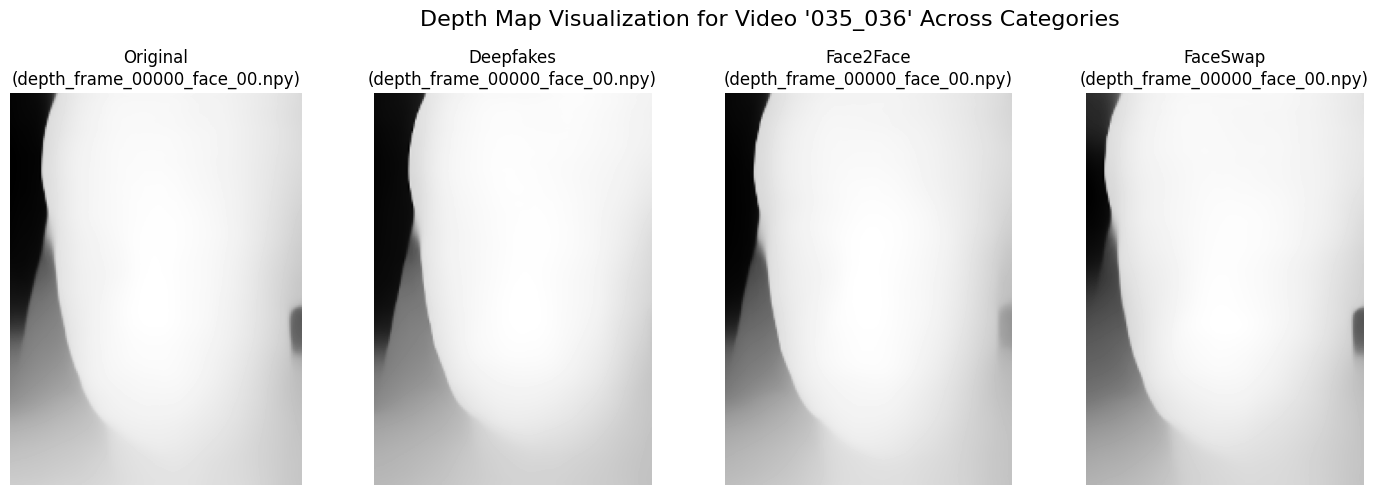


--- depth map visualization complete! ---


In [18]:
# depth map visualization for video 035 across categories
import matplotlib.pyplot as plt
import numpy as np
import os
import glob
import cv2 # For potential image processing if needed, though numpy is primary for.npy

print("\n--- starting depth map visualization for video '035' ---")

video_id_to_visualize_original = '035'
video_id_to_visualize = '035_036'

manipulation_categories = {
    'Original': os.path.join(OUTPUT_DEPTH_MAP_DIR, 'original_sequences', 'youtube', 'c23', 'videos', video_id_to_visualize_original),
    'Deepfakes': os.path.join(OUTPUT_DEPTH_MAP_DIR, 'manipulated_sequences', 'Deepfakes', 'c23', 'videos', video_id_to_visualize),
    'Face2Face': os.path.join(OUTPUT_DEPTH_MAP_DIR, 'manipulated_sequences', 'Face2Face', 'c23', 'videos', video_id_to_visualize),
    'FaceSwap': os.path.join(OUTPUT_DEPTH_MAP_DIR, 'manipulated_sequences', 'FaceSwap', 'c23', 'videos', video_id_to_visualize)
}

fig, axes = plt.subplots(1, len(manipulation_categories), figsize=(16, 5))
fig.suptitle(f"Depth Map Visualization for Video '{video_id_to_visualize}' Across Categories", fontsize=16)

for i, (category_name, category_dir) in enumerate(manipulation_categories.items()):
    depth_files = sorted(glob.glob(os.path.join(category_dir, '*.npy')))
    
    if not depth_files:
        print(f"Warning: No depth maps found for {category_name} in {category_dir}")
        axes[i].set_title(f"{category_name}\n(No Data)")
        axes[i].axis('off')
        continue
    
    # load the first depth map found for visualization
    depth_map_path = depth_files[0]  
    depth_map = np.load(depth_map_path)
    
    # normalize depth map for visualization 
    if depth_map.max() - depth_map.min() > 1e-6: # Avoid division by zero for flat maps
        normalized_depth_map = (depth_map - depth_map.min()) / (depth_map.max() - depth_map.min())
    else:
        normalized_depth_map = np.zeros_like(depth_map) # All zeros if flat
    
    # display the depth map
    im = axes[i].imshow(normalized_depth_map, cmap='gray') # 'gray' colormap is typical for depth
    axes[i].set_title(f"{category_name}\n({os.path.basename(depth_map_path)})")
    axes[i].axis('off') # hide axes ticks and labels

plt.tight_layout(rect=[0, 0, 0.9, 1]) # adjust layout
plt.show()

print("\n--- depth map visualization complete! ---")

In [19]:
%%writefile /kaggle/working/depth_manual_runner.py
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import PIL.Image
import sys
import os
import cv2
from collections import OrderedDict

# define device (cpu/gpu)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"MiDaS will use device: {device}")

# global MiDaS model instance and transforms
midas_model = None
midas_transforms = None

# define a target image size for consistent input to MiDaS
# MiDaS models typically expect RGB images, so we'll load them as such.
target_image_size_midas = (384, 384) 

def load_midas_model_manual():
    global midas_model, midas_transforms
    if midas_model is None:
        print("loading MiDaS model from torch.hub...")
        try:
            # choose a MiDaS model type. DPT_Large is high accuracy.
            model_type = "DPT_Large" 

            midas_model = torch.hub.load("intel-isl/MiDaS", model_type).to(device)
            midas_model.eval()

            midas_transforms = torch.hub.load("intel-isl/MiDaS", "transforms")
            print("MiDaS model loaded successfully from torch.hub.")

        except Exception as e:
            print(f"error loading MiDaS model: {e}")
            print("please check internet connection and model availability on torch.hub.")
            raise
    return midas_model, midas_transforms

# function to estimate depth with MiDaS
def estimate_depth_midas(image_path):
    model, transforms = load_midas_model_manual()

    # load image as RGB for MiDaS
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Image not found at {image_path}")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 

    # apply MiDaS specific transforms
    # DPT_Large uses dpt_transform
    input_batch = transforms.dpt_transform(img).to(device)

    with torch.no_grad():
        prediction = model(input_batch)

        # resize prediction to original image resolution
        prediction = torch.nn.functional.interpolate(
            prediction.unsqueeze(1),
            size=img.shape[:2],
            mode="bicubic",
            align_corners=False,
        ).squeeze()

    # convert to numpy and return
    depth_map = prediction.cpu().numpy()
    return depth_map

# function to save depth map as.npy (for full precision)
def save_depth_map_npy(depth_map_array, output_path):
    np.save(output_path, depth_map_array)

# function to save depth map as normalized grayscale PNG (for visualization)
def save_depth_map_png(depth_map_array, output_path):
    # normalize to 0-255 for image saving
    normalized_depth_map = (depth_map_array - depth_map_array.min()) / \
                           (depth_map_array.max() - depth_map_array.min() + 1e-6) * 255
    normalized_depth_map = normalized_depth_map.astype(np.uint8)
    PIL.Image.fromarray(normalized_depth_map).save(output_path)

Overwriting /kaggle/working/depth_manual_runner.py


In [46]:
# custom dataset and transforms (now supports flow and depth)
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import os
import glob
import numpy as np
import cv2
from tqdm.notebook import tqdm
import random
from sklearn.model_selection import train_test_split
from torchvision.transforms import v2 as transforms_v2

print(f"input_cropped_faces_dir: {INPUT_CROPPED_FACES_DIR}")
print(f"output_optical_flow_dir: {OUTPUT_OPTICAL_FLOW_DIR}")
print(f"output_depth_map_dir: {OUTPUT_DEPTH_MAP_DIR}")

class DeepfakeDetectionFlowDepthDataset(Dataset):
    def __init__(self, flows_root_dir, depth_root_dir, video_ids_to_include=None, transform=None, num_samples_per_video=1):
        self.flows_root_dir = flows_root_dir
        self.depth_root_dir = depth_root_dir
        self.transform = transform
        self.num_samples_per_video = num_samples_per_video
        self.samples = [] # stores (flow_path, depth_path, label)
        self.video_ids_to_include = video_ids_to_include if video_ids_to_include is not None else []

        print(f"debug dataset: initializing with flows_root_dir={self.flows_root_dir}, "
              f"depth_root_dir={self.depth_root_dir}, "
              f"num_videos_to_include={len(self.video_ids_to_include)}")

        if not os.path.exists(self.flows_root_dir):
            print(f"critical error: optical flow root directory does not exist: {self.flows_root_dir}")
        if not os.path.exists(self.depth_root_dir):
            print(f"critical error: depth map root directory does not exist: {self.depth_root_dir}")
            
        self._load_samples()

    def _load_samples(self):
        manipulation_techniques = ['Deepfakes', 'Face2Face', 'FaceSwap']

        original_flows_base = os.path.join(self.flows_root_dir, 'original_sequences', 'youtube', 'c23', 'videos')
        original_depths_base = os.path.join(self.depth_root_dir, 'original_sequences', 'youtube', 'c23', 'videos')

        print(f"\nchecking base paths for flows: original={original_flows_base}")
        print(f"checking base paths for depths: original={original_depths_base}")

        def get_modality_video_dir(base_root_dir, video_id, is_real, tech=None):
            if is_real:
                # CORRECTED path for real videos
                return os.path.join(base_root_dir, 'original_sequences', 'youtube', 'c23', 'videos', video_id)
            else:
                return os.path.join(base_root_dir, 'manipulated_sequences', tech, 'c23', 'videos', video_id)

        # debug
        debug_count = 0
        for video_id, label_val in self.video_ids_to_include[:3]:  
            is_real = (label_val == 0)
            tech = None
            if not is_real:
                for t in manipulation_techniques:
                    test_path = os.path.join(self.flows_root_dir, 'manipulated_sequences', t, 'c23', 'videos', video_id)
                    if os.path.exists(test_path):
                        tech = t
                        break

            flows_vid_dir = get_modality_video_dir(self.flows_root_dir, video_id, is_real, tech)
            depths_vid_dir = get_modality_video_dir(self.depth_root_dir, video_id, is_real, tech)

            print(f"\nDEBUG - Video {video_id} (label={label_val}):")
            print(f"  Flow dir: {flows_vid_dir}")
            print(f"  Flow dir exists: {os.path.exists(flows_vid_dir)}")
            print(f"  Depth dir: {depths_vid_dir}")
            print(f"  Depth dir exists: {os.path.exists(depths_vid_dir)}")
            
            if os.path.exists(flows_vid_dir):
                flow_files = sorted(glob.glob(os.path.join(flows_vid_dir, '*.flo')))
                print(f"  Flow files found: {len(flow_files)}")
                if flow_files:
                    print(f"  Sample flow files: {flow_files[:3]}")
                    
            if os.path.exists(depths_vid_dir):
                depth_files = sorted(glob.glob(os.path.join(depths_vid_dir, '*.npy')))
                print(f"  Depth files found: {len(depth_files)}")
                if depth_files:
                    print(f"  Sample depth files: {depth_files[:3]}")

        # collect all possible samples first, then sample.
        all_possible_samples = []
        for video_id, label_val in tqdm(self.video_ids_to_include, desc="collecting flow and depth pairs"):
            is_real = (label_val == 0)
            tech = None
            if not is_real:
                found_tech = False
                for t in manipulation_techniques:
                    test_path = os.path.join(self.flows_root_dir, 'manipulated_sequences', t, 'c23', 'videos', video_id)
                    if os.path.exists(test_path):
                        tech = t
                        found_tech = True
                        break
                if not found_tech:
                    continue

            flows_vid_dir = get_modality_video_dir(self.flows_root_dir, video_id, is_real, tech)
            depths_vid_dir = get_modality_video_dir(self.depth_root_dir, video_id, is_real, tech)

            if not os.path.exists(flows_vid_dir) or not os.path.exists(depths_vid_dir):
                continue

            all_flo_files = sorted(glob.glob(os.path.join(flows_vid_dir, '*.flo')))
            all_depth_files = sorted(glob.glob(os.path.join(depths_vid_dir, '*.npy')))
            
            for flow_p in all_flo_files:
                flow_basename = os.path.basename(flow_p)
                corresponding_depth_path = None
                
                parts = flow_basename.split('_')
                if len(parts) >= 3 and parts[0] == 'flow' and parts[1].startswith('frame'):
                    first_frame_name = parts[1]
                    depth_filename = f"depth_{first_frame_name}.npy"
                    corresponding_depth_path = os.path.join(depths_vid_dir, depth_filename)
                
                if not corresponding_depth_path or not os.path.exists(corresponding_depth_path):
                    depth_filename = flow_basename.replace('flow_', 'depth_').replace('.flo', '.npy')
                    corresponding_depth_path = os.path.join(depths_vid_dir, depth_filename)
                
                if not corresponding_depth_path or not os.path.exists(corresponding_depth_path):
                    import re
                    flow_numbers = re.findall(r'\d+', flow_basename)
                    if flow_numbers:
                        for depth_file in all_depth_files:
                            depth_numbers = re.findall(r'\d+', os.path.basename(depth_file))
                            if depth_numbers and flow_numbers[0] == depth_numbers[0]:
                                corresponding_depth_path = depth_file
                                break
                
                if not corresponding_depth_path or not os.path.exists(corresponding_depth_path):
                    if len(all_flo_files) == len(all_depth_files):
                        flow_idx = all_flo_files.index(flow_p)
                        if flow_idx < len(all_depth_files):
                            corresponding_depth_path = all_depth_files[flow_idx]

                if corresponding_depth_path and os.path.exists(corresponding_depth_path):
                    all_possible_samples.append((flow_p, corresponding_depth_path, label_val))

        print(f"Total flow-depth pairs found: {len(all_possible_samples)}")

        # group by video_id and sample
        samples_by_video = {}
        for flow_p, depth_p, label_val in all_possible_samples:
            video_id = os.path.basename(os.path.dirname(flow_p))
            if video_id not in samples_by_video:
                samples_by_video[video_id] = []
            samples_by_video[video_id].append((flow_p, depth_p, label_val))

        self.samples = []
        for video_id, label_val in self.video_ids_to_include:
            if video_id in samples_by_video:
                available_samples = samples_by_video[video_id]
                num_to_sample = min(self.num_samples_per_video, len(available_samples))
                if num_to_sample > 0:
                    self.samples.extend(random.sample(available_samples, num_to_sample))

        print(f"dataset loaded. total samples (flow, depth, label): {len(self.samples)}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        flow_path, depth_path, label = self.samples[idx]

        flow_data_np = self._load_flo_file(flow_path)
        depth_data_np = self._load_npy_file(depth_path)

        # optical flow normalization
        max_flow_magnitude = 20.0
        normalized_flow_data = flow_data_np / max_flow_magnitude
        flow_tensor = torch.from_numpy(normalized_flow_data).permute(2, 0, 1).float()

        # depth map normalization and conversion
        if depth_data_np.max() - depth_data_np.min() > 1e-6:
            normalized_depth_data = (depth_data_np - depth_data_np.min()) / \
                                    (depth_data_np.max() - depth_data_np.min())
        else:
            normalized_depth_data = np.zeros_like(depth_data_np, dtype=np.float32)

        depth_tensor = torch.from_numpy(normalized_depth_data).unsqueeze(0).float()

        # apply transformations to both tensors
        if self.transform:
            flow_tensor = self.transform(flow_tensor)
            depth_tensor = self.transform(depth_tensor)

        return flow_tensor, depth_tensor, torch.tensor(label, dtype=torch.float32)

    def _load_flo_file(self, filepath):
        """loads a.flo file."""
        with open(filepath, 'rb') as f:
            tag = np.fromfile(f, np.float32, count=1)
            if tag != 202021.25: 
                raise Exception(f'bad.flo file tag! {filepath}')
            width = int(np.fromfile(f, np.int32, count=1).item())
            height = int(np.fromfile(f, np.int32, count=1).item())
            data = np.fromfile(f, np.float32, count=height * width * 2)
        flow = np.reshape(data, (height, width, 2))
        return flow

    def _load_npy_file(self, filepath):
        """loads a.npy file (assumed to be a depth map)."""
        return np.load(filepath).astype(np.float32)


# --- dataset instantiation block ---

target_size = 224

train_transform = transforms_v2.Compose([
    transforms_v2.Resize((target_size, target_size)),
    transforms_v2.RandomHorizontalFlip(p=0.5),
    transforms_v2.RandomRotation(degrees=10),
    transforms_v2.Normalize(mean=[0.5], std=[0.5])
])

val_transform = transforms_v2.Compose([
    transforms_v2.Resize((target_size, target_size)),
    transforms_v2.Normalize(mean=[0.5], std=[0.5])
])

num_samples_per_video = 50

def get_all_video_info(frames_root_dir, flows_root_dir, depths_root_dir):
    """
    scans the dataset structure to get all video_ids and their labels (0 for real, 1 for fake),
    along with their corresponding flow and depth directories.
    """
    all_video_data = []

    manipulation_techniques = ['Deepfakes', 'Face2Face', 'FaceSwap']

    original_flows_base = os.path.join(flows_root_dir, 'original_sequences', 'youtube', 'c23', 'videos')
    original_depths_base = os.path.join(depths_root_dir, 'original_sequences', 'youtube', 'c23', 'videos')

    if os.path.exists(original_flows_base) and os.path.exists(original_depths_base):
        for video_id in os.listdir(original_flows_base):
            video_flow_dir = os.path.join(original_flows_base, video_id)
            video_depth_dir = os.path.join(original_depths_base, video_id)
            if os.path.isdir(video_flow_dir) and os.path.isdir(video_depth_dir) and \
               len(glob.glob(os.path.join(video_flow_dir, '*.flo'))) > 0 and \
               len(glob.glob(os.path.join(video_depth_dir, '*.npy'))) > 0:
                all_video_data.append((video_id, 0))
    else:
        print(f"warning: original flows or depths base not found: flows={original_flows_base}, depths={original_depths_base}")

    for tech in manipulation_techniques:
        manipulated_flows_base_tech = os.path.join(flows_root_dir, 'manipulated_sequences', tech, 'c23', 'videos')
        manipulated_depths_base_tech = os.path.join(depths_root_dir, 'manipulated_sequences', tech, 'c23', 'videos')
        if os.path.exists(manipulated_flows_base_tech) and os.path.exists(manipulated_depths_base_tech):
            for video_id in os.listdir(manipulated_flows_base_tech):
                video_flow_dir = os.path.join(manipulated_flows_base_tech, video_id)
                video_depth_dir = os.path.join(manipulated_depths_base_tech, video_id)
                if os.path.isdir(video_flow_dir) and os.path.isdir(video_depth_dir) and \
                   len(glob.glob(os.path.join(video_flow_dir, '*.flo'))) > 0 and \
                   len(glob.glob(os.path.join(video_depth_dir, '*.npy'))) > 0:
                    all_video_data.append((video_id, 1))
        else:
            print(f"warning: manipulated flows or depths base not found for {tech}: flows={manipulated_flows_base_tech}, depths={manipulated_depths_base_tech}")

    print(f"total unique videos found for splitting: {len(all_video_data)}")
    return all_video_data

# get all video data
all_videos_with_labels = get_all_video_info(INPUT_CROPPED_FACES_DIR, OUTPUT_OPTICAL_FLOW_DIR, OUTPUT_DEPTH_MAP_DIR)

if not all_videos_with_labels:
    raise ValueError("no video data found. please check your input paths and flow/depth generation.")

video_ids = [item[0] for item in all_videos_with_labels]
labels = [item[1] for item in all_videos_with_labels]

train_val_ids, test_ids, train_val_labels, test_labels = train_test_split(
    all_videos_with_labels, labels, test_size=0.15, random_state=42, stratify=labels
)

train_ids, val_ids, _, _ = train_test_split(
    train_val_ids, train_val_labels, test_size=0.15/(1-0.15), random_state=42, stratify=train_val_labels
)

print(f"train videos: {len(train_ids)}")
print(f"validation videos: {len(val_ids)}")
print(f"test videos: {len(test_ids)}")

# instantiate datasets
print("\ninitializing training dataset...")
train_dataset = DeepfakeDetectionFlowDepthDataset(
    flows_root_dir=OUTPUT_OPTICAL_FLOW_DIR,
    depth_root_dir=OUTPUT_DEPTH_MAP_DIR,
    video_ids_to_include=train_ids,
    transform=train_transform,
    num_samples_per_video=num_samples_per_video
)

if len(train_dataset) == 0:
    print("ERROR: No training samples found. Please check the file naming conventions and paths.")
    print("The debug output above should help identify the issue.")
else:
    print("\ninitializing validation dataset...")
    val_dataset = DeepfakeDetectionFlowDepthDataset(
        flows_root_dir=OUTPUT_OPTICAL_FLOW_DIR,
        depth_root_dir=OUTPUT_DEPTH_MAP_DIR,
        video_ids_to_include=val_ids,
        transform=val_transform,
        num_samples_per_video=num_samples_per_video
    )

    print("\ninitializing test dataset...")
    test_dataset = DeepfakeDetectionFlowDepthDataset(
        flows_root_dir=OUTPUT_OPTICAL_FLOW_DIR,
        depth_root_dir=OUTPUT_DEPTH_MAP_DIR,
        video_ids_to_include=test_ids,
        transform=val_transform,
        num_samples_per_video=num_samples_per_video
    )

    batch_size = 16

    if len(train_dataset) > 0:
        train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, 
                                num_workers=os.cpu_count() if os.cpu_count() > 0 else 2, pin_memory=True)
        print(f"train loader has {len(train_loader)} batches.")
    
    if len(val_dataset) > 0:
        val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, 
                              num_workers=os.cpu_count() if os.cpu_count() > 0 else 2, pin_memory=True)
        print(f"validation loader has {len(val_loader)} batches.")
    
    if len(test_dataset) > 0:
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, 
                               num_workers=os.cpu_count() if os.cpu_count() > 0 else 2, pin_memory=True)
        print(f"test loader has {len(test_loader)} batches.")

input_cropped_faces_dir: /kaggle/input/croppedfaces/FaceForensics_CroppedFaces_Sampled
output_optical_flow_dir: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT
output_depth_map_dir: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS
total unique videos found for splitting: 347
train videos: 242
validation videos: 52
test videos: 53

initializing training dataset...
debug dataset: initializing with flows_root_dir=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT, depth_root_dir=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS, num_videos_to_include=242

checking base paths for flows: original=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/original_sequences/youtube/c23/videos
checking base paths for depths: original=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS/original_sequences/youtube/c23/videos

DEBUG - Video 794_779 (label=1):
  Flow dir: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/manipulated_sequences/Deepfakes/c23/videos/794_779
  Flow

collecting flow and depth pairs:   0%|          | 0/242 [00:00<?, ?it/s]

Total flow-depth pairs found: 3963
dataset loaded. total samples (flow, depth, label): 6193

initializing validation dataset...
debug dataset: initializing with flows_root_dir=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT, depth_root_dir=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS, num_videos_to_include=52

checking base paths for flows: original=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/original_sequences/youtube/c23/videos
checking base paths for depths: original=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS/original_sequences/youtube/c23/videos

DEBUG - Video 779 (label=0):
  Flow dir: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/original_sequences/youtube/c23/videos/779
  Flow dir exists: True
  Depth dir: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS/original_sequences/youtube/c23/videos/779
  Depth dir exists: True
  Flow files found: 9
  Sample flow files: ['/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/original_seq

collecting flow and depth pairs:   0%|          | 0/52 [00:00<?, ?it/s]

Total flow-depth pairs found: 854
dataset loaded. total samples (flow, depth, label): 960

initializing test dataset...
debug dataset: initializing with flows_root_dir=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT, depth_root_dir=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS, num_videos_to_include=53

checking base paths for flows: original=/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/original_sequences/youtube/c23/videos
checking base paths for depths: original=/kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS/original_sequences/youtube/c23/videos

DEBUG - Video 897_969 (label=1):
  Flow dir: /kaggle/working/FaceForensics_OpticalFlow_Sampled_RAFT/manipulated_sequences/Deepfakes/c23/videos/897_969
  Flow dir exists: True
  Depth dir: /kaggle/working/FaceForensics_DepthMap_Sampled_MiDaS/manipulated_sequences/Deepfakes/c23/videos/897_969
  Depth dir exists: True
  Flow files found: 7
  Sample flow files: ['/kaggle/working/FaceForensics_OpticalFlow_Sampled_RAF

collecting flow and depth pairs:   0%|          | 0/53 [00:00<?, ?it/s]

Total flow-depth pairs found: 837
dataset loaded. total samples (flow, depth, label): 1026
train loader has 388 batches.
validation loader has 60 batches.
test loader has 65 batches.


In [49]:
import torch
import torch.nn as nn
from torchvision import models
from torchvision.models import ResNet18_Weights
import torch.nn.functional as F

# --- feature Extractors ---

class FlowFeatureExtractor(nn.Module):
    def __init__(self):
        super(FlowFeatureExtractor, self).__init__()

        original_resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # modify conv1 to accept 2 channels (optical flow)
        self.resnet_conv1 = nn.Conv2d(2, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet_conv1.weight.data = original_resnet.conv1.weight.data[:, :2, :, :]

        # use ResNet layers excluding conv1, avgpool, fc
        self.resnet_layers = nn.Sequential(*list(original_resnet.children())[1:-1])

    def forward(self, x):
        x = self.resnet_conv1(x)
        x = self.resnet_layers(x)
        return x  

class DepthFeatureExtractor(nn.Module):
    def __init__(self):
        super(DepthFeatureExtractor, self).__init__()

        original_resnet = models.resnet18(weights=ResNet18_Weights.DEFAULT)

        # modify conv1 to accept 1 channel (depth)
        self.resnet_conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet_conv1.weight.data = original_resnet.conv1.weight.data.mean(dim=1, keepdim=True)

        self.resnet_layers = nn.Sequential(*list(original_resnet.children())[1:-1])

    def forward(self, x):
        x = self.resnet_conv1(x)
        x = self.resnet_layers(x)
        return x 

# --- combined Model with Transformer ---

class FlowBasedDeepfakeDetectorWithTransformer(nn.Module):
    def __init__(self, num_classes=1, flow_embed_dim=512, depth_embed_dim=512, num_heads=8, num_layers=6, dropout_rate=0.1):
        super(FlowBasedDeepfakeDetectorWithTransformer, self).__init__()

        self.flow_feature_extractor = FlowFeatureExtractor()
        self.depth_feature_extractor = DepthFeatureExtractor()

        self.combined_embed_dim = flow_embed_dim + depth_embed_dim

        self.dropout_after_features = nn.Dropout(p=dropout_rate)

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=self.combined_embed_dim,
            nhead=num_heads,
            batch_first=True,
            dropout=dropout_rate
        )
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.flatten_features = nn.Flatten(start_dim=2)
        self.dropout_after_transformer = nn.Dropout(p=dropout_rate)
        self.classifier = nn.Linear(self.combined_embed_dim, num_classes)
        self.quant = torch.quantization.QuantStub()
        self.dequant = torch.quantization.DeQuantStub()


    def forward(self, flow_images, depth_images):
        flow_images = self.quant(flow_images)
        depth_images = self.quant(depth_images)
        
        flow_features = self.flow_feature_extractor(flow_images)  # (B, 512, 7, 7)
        depth_features = self.depth_feature_extractor(depth_images)  # (B, 512, 7, 7)

        flow_flat = self.flatten_features(flow_features).permute(0, 2, 1)   # (B, 49, 512)
        depth_flat = self.flatten_features(depth_features).permute(0, 2, 1) # (B, 49, 512)

        combined = torch.cat((flow_flat, depth_flat), dim=2)  # (B, 49, 1024)
        combined = self.dropout_after_features(combined)

        transformer_out = self.transformer_encoder(combined)
        pooled = torch.mean(transformer_out, dim=1)  # (B, 1024)

        pooled = self.dropout_after_transformer(pooled)
        output = self.classifier(pooled)
        output = self.dequant(output)
        return output  # logits

# --- model Initialization ---

flow_embed_dim = 512
depth_embed_dim = 512
model_combined_embed_dim = flow_embed_dim + depth_embed_dim
model_num_heads = 8
model_num_layers = 6
num_classes = 1  # Binary classification

model = FlowBasedDeepfakeDetectorWithTransformer(
    num_classes=num_classes,
    flow_embed_dim=flow_embed_dim,
    depth_embed_dim=depth_embed_dim,
    num_heads=model_num_heads,
    num_layers=model_num_layers
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

print(f"✅ Model ready on device: {device}")
print(f"Combined embedding dim: {model.combined_embed_dim}")


✅ Model ready on device: cuda
Combined embedding dim: 1024


In [50]:
# hyperparameter grid search

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
import time
from tqdm.notebook import tqdm
from itertools import product
from torch.utils.data import DataLoader 

# --- calculate pos_weight for BCEWithLogitsLoss to handle class imbalance ---
print("Calculating pos_weight from train_dataset...")
positive_samples = 0
negative_samples = 0

for i in tqdm(range(len(train_dataset)), desc="Counting samples for pos_weight"):
    try:
        _, _, label_tensor = train_dataset[i]

        label = label_tensor.squeeze().item()

        if label == 1: # assuming '1' is the positive class
            positive_samples += 1
        else: # assuming '0' is the negative class 
            negative_samples += 1
    except Exception as e:
        print(f"Warning: Could not process sample {i} for pos_weight calculation: {e}. Skipping.")
        continue

if positive_samples == 0 and negative_samples == 0:
    print("Error: train_dataset appears empty or failed to load any samples for pos_weight calculation.")
    # fallback to a neutral pos_weight if no samples were processed
    pos_weight = torch.tensor([1.0], device=device)
    print("Setting pos_weight to 1.0. Consider checking your train_dataset.")
elif positive_samples == 0:
    print("Warning: No positive samples found in train_dataset. Setting pos_weight to 1.0 (no weighting).")
    pos_weight = torch.tensor([1.0], device=device)
else:
    # calculate the weighting factor: number of negative samples / number of positive samples
    pos_weight_value = float(negative_samples) / positive_samples
    pos_weight = torch.tensor([pos_weight_value], device=device)
    print(f"Calculated pos_weight: {pos_weight_value:.4f} "
          f"(Negative samples: {negative_samples}, Positive samples: {positive_samples})")

fixed_batch_size = 32 

train_loader = DataLoader(train_dataset, batch_size=fixed_batch_size, shuffle=True, num_workers=os.cpu_count() if os.cpu_count() > 0 else 2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=fixed_batch_size, shuffle=False, num_workers=os.cpu_count() if os.cpu_count() > 0 else 2, pin_memory=True)

print(f"debug: train_loader has {len(train_loader)} batches.")
print(f"debug: val_loader has {len(val_loader)} batches.")

# --- define your hyperparameter options ---
param_grid = {
    'learning_rate': [0.0001, 0.00001], 
    'weight_decay': [0.0, 1e-4],     
    'scheduler_type': ['steplr', 'reducelronplateau'],
    'step_lr_gamma': [0.1],       
    'rlr_patience': [3],      
}


model_fixed_params = {
    'num_classes': 1,
    'flow_embed_dim': flow_embed_dim,
    'depth_embed_dim': depth_embed_dim, 
    'num_heads': 8,
    'num_layers': 6
}

# --- function to train one model run ---
def train_model_single_run(
    current_lr,
    current_weight_decay,
    current_scheduler_type,
    current_scheduler_gamma,
    current_scheduler_patience,
    num_epochs,
    pos_weight, 
    train_loader,
    val_loader,
    device,
    model_params
):

    model = FlowBasedDeepfakeDetectorWithTransformer(
        num_classes=model_params['num_classes'],
        flow_embed_dim=model_params['flow_embed_dim'],
        depth_embed_dim=model_params['depth_embed_dim'],
        num_heads=model_params['num_heads'],
        num_layers=model_params['num_layers']
    ).to(device)

    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
    optimizer = optim.Adam(model.parameters(), lr=current_lr, weight_decay=current_weight_decay)

    scheduler = None
    if current_scheduler_type == 'steplr':
        scheduler = StepLR(optimizer, step_size=5, gamma=current_scheduler_gamma)
    elif current_scheduler_type == 'reducelronplateau':
        scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=current_scheduler_patience)

    best_val_loss_run = float('inf')
    best_model_state_run = None
    early_stopping_patience_counter = 0
    early_stopping_patience = 5 

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct_train = 0
        total_train = 0 

        try:
            if len(train_loader) == 0:
                print(f"warning: train_loader is empty for epoch {epoch}. skipping training.")
                avg_train_loss = float('nan')
                avg_train_acc = float('nan')
            else:
                for flows, depths, labels in tqdm(train_loader, desc=f"epoch [{epoch}/{num_epochs}] training"):
                    flows = flows.to(device)
                    depths = depths.to(device)
                    labels = labels.to(device)

                    optimizer.zero_grad()
                    outputs = model(flows, depths).squeeze(1)
                    loss = criterion(outputs, labels)
                    loss.backward()
                    optimizer.step()

                    running_loss += loss.item() * flows.size(0)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total_train += labels.size(0)
                    correct_train += (predicted == labels).sum().item()

                if total_train == 0:
                    print(f"warning: no training samples processed for epoch {epoch}. check your data.")
                    avg_train_loss = float('nan')
                    avg_train_acc = float('nan')
                else:
                    avg_train_loss = running_loss / total_train
                    avg_train_acc = correct_train / total_train

        except Exception as e:
            print(f"critical error during training (epoch {epoch}): {e}")
            avg_train_loss = float('nan')
            avg_train_acc = float('nan')

        model.eval()
        running_val_loss = 0.0
        correct_val = 0
        total_val = 0

        try:
            if len(val_loader) == 0:
                print(f"warning: val_loader is empty for epoch {epoch}. skipping validation.")
                avg_val_loss = float('inf')
                avg_val_acc = float('nan')
            else:
                with torch.no_grad():
                    for flows, depths, labels in tqdm(val_loader, desc=f"epoch [{epoch}/{num_epochs}] validation"):
                        flows = flows.to(device)
                        depths = depths.to(device)
                        labels = labels.to(device)
                        outputs = model(flows, depths).squeeze(1)
                        loss = criterion(outputs, labels)
                        running_val_loss += loss.item() * flows.size(0)
                        predicted = (torch.sigmoid(outputs) > 0.5).float()
                        total_val += labels.size(0)
                        correct_val += (predicted == labels).sum().item()

                if total_val == 0:
                    print(f"warning: no validation samples processed for epoch {epoch}. check your data.")
                    avg_val_loss = float('inf')
                    avg_val_acc = float('nan')
                else:
                    avg_val_loss = running_val_loss / total_val
                    avg_val_acc = correct_val / total_val

        except Exception as e:
            print(f"critical error during validation (epoch {epoch}): {e}")
            avg_val_loss = float('inf')
            avg_val_acc = float('nan')

        print(f"\n--- epoch {epoch} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f} ---")

        if scheduler:
            if current_scheduler_type == 'steplr':
                scheduler.step()
            elif current_scheduler_type == 'reducelronplateau':
                scheduler.step(avg_val_loss)

        # save best model and check early stopping
        if avg_val_loss < best_val_loss_run:
            best_val_loss_run = avg_val_loss
            best_model_state_run = model.state_dict()
            early_stopping_patience_counter = 0
        else:
            early_stopping_patience_counter += 1
            if early_stopping_patience_counter >= early_stopping_patience:
                print(f"early stopping hit for this run at epoch {epoch}.")
                break

    return best_val_loss_run, best_model_state_run

# --- run the grid search ---
best_overall_val_loss = float('inf')
best_hyperparams = {}
final_best_model_state = None

print("starting grid search...")

scheduler_params_list = []
for gamma in param_grid['step_lr_gamma']:
    scheduler_params_list.append(('steplr', gamma, None))
for patience in param_grid['rlr_patience']:
    scheduler_params_list.append(('reducelronplateau', None, patience))

keys = ['learning_rate', 'weight_decay', 'scheduler_config']
values = [param_grid['learning_rate'], param_grid['weight_decay'], scheduler_params_list]

num_epochs_per_trial = 5

for combo in product(*values):
    current_lr, current_weight_decay, (current_scheduler_type, current_scheduler_gamma, current_scheduler_patience) = combo

    print(f"\n--- trying combo: lr={current_lr}, wd={current_weight_decay}, "
          f"scheduler={current_scheduler_type} (gamma={current_scheduler_gamma}, patience={current_scheduler_patience}) ---")

    val_loss, model_state = train_model_single_run(
        current_lr=current_lr,
        current_weight_decay=current_weight_decay,
        current_scheduler_type=current_scheduler_type,
        current_scheduler_gamma=current_scheduler_gamma,
        current_scheduler_patience=current_scheduler_patience,
        num_epochs=num_epochs_per_trial, 
        pos_weight=pos_weight, 
        train_loader=train_loader,
        val_loader=val_loader,
        device=device,
        model_params=model_fixed_params
    )

    if val_loss < best_overall_val_loss:
        best_overall_val_loss = val_loss
        best_hyperparams = {
            'learning_rate': current_lr,
            'weight_decay': current_weight_decay,
            'scheduler_type': current_scheduler_type,
            'step_lr_gamma': current_scheduler_gamma,
            'rlr_patience': current_scheduler_patience,
            **model_fixed_params
        }
        final_best_model_state = model_state
        print(f"new best overall validation loss: {best_overall_val_loss:.4f}")
        print(f"best hyperparameters so far: {best_hyperparams}")

print("\n--- grid search finished ---")
print(f"best overall validation loss: {best_overall_val_loss:.4f}")
print(f"best hyperparameters found: {best_hyperparams}")

# save model
if final_best_model_state:
    torch.save(final_best_model_state, 'grid_search_best_model_flow_depth_transformer.pth')
    print("best model from grid search saved as 'grid_search_best_model_flow_depth_transformer.pth'")

Calculating pos_weight from train_dataset...


Counting samples for pos_weight:   0%|          | 0/6193 [00:00<?, ?it/s]

Calculated pos_weight: 0.2191 (Negative samples: 1113, Positive samples: 5080)
debug: train_loader has 194 batches.
debug: val_loader has 30 batches.
starting grid search...

--- trying combo: lr=0.0001, wd=0.0, scheduler=steplr (gamma=0.1, patience=None) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2428, validation loss: 0.3470 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2069, validation loss: 0.3349 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1911, validation loss: 0.4242 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1772, validation loss: 0.4036 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1748, validation loss: 0.2891 ---
new best overall validation loss: 0.2891
best hyperparameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.0, 'scheduler_type': 'steplr', 'step_lr_gamma': 0.1, 'rlr_patience': None, 'num_classes': 1, 'flow_embed_dim': 512, 'depth_embed_dim': 512, 'num_heads': 8, 'num_layers': 6}

--- trying combo: lr=0.0001, wd=0.0, scheduler=reducelronplateau (gamma=None, patience=3) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2422, validation loss: 0.2758 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2043, validation loss: 0.2881 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.2064, validation loss: 0.2900 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1805, validation loss: 0.3813 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1816, validation loss: 0.3625 ---
new best overall validation loss: 0.2758
best hyperparameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.0, 'scheduler_type': 'reducelronplateau', 'step_lr_gamma': None, 'rlr_patience': 3, 'num_classes': 1, 'flow_embed_dim': 512, 'depth_embed_dim': 512, 'num_heads': 8, 'num_layers': 6}

--- trying combo: lr=0.0001, wd=0.0001, scheduler=steplr (gamma=0.1, patience=None) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2424, validation loss: 0.2660 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2104, validation loss: 0.2850 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1981, validation loss: 0.2788 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.2079, validation loss: 0.2830 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1778, validation loss: 0.3477 ---
new best overall validation loss: 0.2660
best hyperparameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.0001, 'scheduler_type': 'steplr', 'step_lr_gamma': 0.1, 'rlr_patience': None, 'num_classes': 1, 'flow_embed_dim': 512, 'depth_embed_dim': 512, 'num_heads': 8, 'num_layers': 6}

--- trying combo: lr=0.0001, wd=0.0001, scheduler=reducelronplateau (gamma=None, patience=3) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2404, validation loss: 0.2754 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2072, validation loss: 0.3087 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1978, validation loss: 0.2762 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1753, validation loss: 0.3576 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1803, validation loss: 0.2615 ---
new best overall validation loss: 0.2615
best hyperparameters so far: {'learning_rate': 0.0001, 'weight_decay': 0.0001, 'scheduler_type': 'reducelronplateau', 'step_lr_gamma': None, 'rlr_patience': 3, 'num_classes': 1, 'flow_embed_dim': 512, 'depth_embed_dim': 512, 'num_heads': 8, 'num_layers': 6}

--- trying combo: lr=1e-05, wd=0.0, scheduler=steplr (gamma=0.1, patience=None) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2357, validation loss: 0.3277 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2055, validation loss: 0.2998 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1806, validation loss: 0.3003 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1610, validation loss: 0.4471 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1489, validation loss: 0.3534 ---

--- trying combo: lr=1e-05, wd=0.0, scheduler=reducelronplateau (gamma=None, patience=3) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2389, validation loss: 0.2657 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2001, validation loss: 0.3110 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1805, validation loss: 0.3298 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1630, validation loss: 0.3826 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1419, validation loss: 0.3553 ---

--- trying combo: lr=1e-05, wd=0.0001, scheduler=steplr (gamma=0.1, patience=None) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2362, validation loss: 0.3099 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2033, validation loss: 0.2705 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1846, validation loss: 0.3226 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1622, validation loss: 0.3260 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1456, validation loss: 0.4607 ---

--- trying combo: lr=1e-05, wd=0.0001, scheduler=reducelronplateau (gamma=None, patience=3) ---


epoch [1/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2363, validation loss: 0.2975 ---


epoch [2/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2041, validation loss: 0.3341 ---


epoch [3/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1775, validation loss: 0.3000 ---


epoch [4/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1642, validation loss: 0.4647 ---


epoch [5/5] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/5] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1461, validation loss: 0.4772 ---

--- grid search finished ---
best overall validation loss: 0.2615
best hyperparameters found: {'learning_rate': 0.0001, 'weight_decay': 0.0001, 'scheduler_type': 'reducelronplateau', 'step_lr_gamma': None, 'rlr_patience': 3, 'num_classes': 1, 'flow_embed_dim': 512, 'depth_embed_dim': 512, 'num_heads': 8, 'num_layers': 6}
best model from grid search saved as 'grid_search_best_model_flow_depth_transformer.pth'


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt # for plotting at the end

# --- best hyperparameters from your grid search ---
best_lr = 0.0001 
best_weight_decay = 1e-3
best_scheduler_type = 'reducelronplateau' 
best_scheduler_gamma = 0.1 
best_rlr_patience = 3 

model_params = {
    'num_classes': 1,
    'flow_embed_dim': flow_embed_dim, 
    'depth_embed_dim': depth_embed_dim,
    'num_heads': 8,
    'num_layers': 6
}

print(f"debug: train_loader has {len(train_loader)} batches.")
print(f"debug: val_loader has {len(val_loader)} batches.")

print("\n--- starting final training with best hyperparameters ---")
print(f"lr: {best_lr}, wd: {best_weight_decay}, scheduler: {best_scheduler_type} (patience: {best_rlr_patience})")

model = FlowBasedDeepfakeDetectorWithTransformer(
    num_classes=model_params['num_classes'],
    flow_embed_dim=model_params['flow_embed_dim'],
    depth_embed_dim=model_params['depth_embed_dim'],
    num_heads=model_params['num_heads'],
    num_layers=model_params['num_layers'],
    dropout_rate=0.1
).to(device)

criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weight)
optimizer = optim.Adam(model.parameters(), lr=best_lr, weight_decay=best_weight_decay)

scheduler = None
if best_scheduler_type == 'steplr':
    scheduler = StepLR(optimizer, step_size=5, gamma=best_scheduler_gamma)
elif best_scheduler_type == 'reducelronplateau':
    scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=best_rlr_patience)

# --- lists to save training and validation metrics for plotting ---
training_losses = []
validation_losses = []
training_accuracies = []
validation_accuracies = []

best_val_loss_epoch = float('inf')
best_model_state_epoch = None
early_stopping_patience_counter = 0
early_stopping_patience = 7 

num_epochs = 50 

for epoch in range(1, num_epochs + 1):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    try:
        if len(train_loader) == 0:
            print(f"warning: train_loader is empty for epoch {epoch}. skipping training.")
            avg_train_loss = float('nan')
            avg_train_acc = float('nan')
        else:
            for flows, depths, labels in tqdm(train_loader, desc=f"epoch [{epoch}/{num_epochs}] training"):
                flows = flows.to(device)
                depths = depths.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()
                outputs = model(flows, depths).squeeze(1)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                running_loss += loss.item() * flows.size(0)
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total_train += labels.size(0)
                correct_train += (predicted == labels).sum().item()

            if total_train == 0:
                print(f"warning: no training samples processed for epoch {epoch}. check your data.")
                avg_train_loss = float('nan')
                avg_train_acc = float('nan')
            else:
                avg_train_loss = running_loss / total_train
                avg_train_acc = correct_train / total_train

    except Exception as e:
        print(f"critical error during training (epoch {epoch}): {e}")
        avg_train_loss = float('nan')
        avg_train_acc = float('nan')

    # validation phase
    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    try:
        if len(val_loader) == 0:
            print(f"warning: val_loader is empty for epoch {epoch}. skipping validation.")
            avg_val_loss = float('inf')
            avg_val_acc = float('nan')
        else:
            with torch.no_grad():
                for flows, depths, labels in tqdm(val_loader, desc=f"epoch [{epoch}/{num_epochs}] validation"):
                    flows = flows.to(device)
                    depths = depths.to(device) 
                    labels = labels.to(device)
                    outputs = model(flows, depths).squeeze(1)
                    loss = criterion(outputs, labels)
                    running_val_loss += loss.item() * flows.size(0)
                    predicted = (torch.sigmoid(outputs) > 0.5).float()
                    total_val += labels.size(0)
                    correct_val += (predicted == labels).sum().item()

            if total_val == 0:
                print(f"warning: no validation samples processed for epoch {epoch}. check your data.")
                avg_val_loss = float('inf')
                avg_val_acc = float('nan')
            else:
                avg_val_loss = running_val_loss / total_val
                avg_val_acc = correct_val / total_val

    except Exception as e:
        print(f"critical error during validation (epoch {epoch}): {e}")
        avg_val_loss = float('inf')
        avg_val_acc = float('nan')

    print(f"\n--- epoch {epoch} training loss: {avg_train_loss:.4f}, validation loss: {avg_val_loss:.4f} ---")

    # --- save metrics for plotting ---
    training_losses.append(avg_train_loss)
    validation_losses.append(avg_val_loss)
    training_accuracies.append(avg_train_acc)
    validation_accuracies.append(avg_val_acc)

    # scheduler step
    if scheduler:
        if best_scheduler_type == 'steplr':
            scheduler.step()
        elif best_scheduler_type == 'reducelronplateau':
            scheduler.step(avg_val_loss)

    # model saving & early stopping logic for this run
    if avg_val_loss < best_val_loss_epoch:
        best_val_loss_epoch = avg_val_loss
        best_model_state_epoch = model.state_dict()
        early_stopping_patience_counter = 0
    else:
        early_stopping_patience_counter += 1
        if early_stopping_patience_counter >= early_stopping_patience:
            print(f"early stopping hit for this final run at epoch {epoch}.")
            break

# save the best model from this run
if best_model_state_epoch:
    torch.save(best_model_state_epoch, 'final_best_model_flow_depth_transformer.pth')
    print("final best model from this run saved as 'final_best_model_flow_depth_transformer.pth'")
else:
    print("warning: no best model state saved (maybe due to empty loaders or errors).")

print("\n--- final training complete ---")

debug: train_loader has 194 batches.
debug: val_loader has 30 batches.

--- starting final training with best hyperparameters ---
lr: 0.0001, wd: 0.001, scheduler: reducelronplateau (patience: 3)


epoch [1/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [1/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 1 training loss: 0.2427, validation loss: 0.2606 ---


epoch [2/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [2/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 2 training loss: 0.2036, validation loss: 0.2584 ---


epoch [3/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [3/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 3 training loss: 0.1913, validation loss: 0.2772 ---


epoch [4/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [4/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 4 training loss: 0.1838, validation loss: 0.2953 ---


epoch [5/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [5/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 5 training loss: 0.1755, validation loss: 0.2910 ---


epoch [6/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [6/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 6 training loss: 0.1630, validation loss: 0.2695 ---


epoch [7/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [7/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 7 training loss: 0.1235, validation loss: 0.2948 ---


epoch [8/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [8/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 8 training loss: 0.1094, validation loss: 0.3149 ---


epoch [9/50] training:   0%|          | 0/194 [00:00<?, ?it/s]

epoch [9/50] validation:   0%|          | 0/30 [00:00<?, ?it/s]


--- epoch 9 training loss: 0.0946, validation loss: 0.3927 ---
early stopping hit for this final run at epoch 9.
final best model from this run saved as 'final_best_model_flow_depth_transformer.pth'

--- final training complete ---


Model loaded successfully from 'final_best_model_flow_depth_transformer.pth'


Evaluating on test set:   0%|          | 0/65 [00:00<?, ?it/s]


--- Evaluation Results ---
Average Test Loss: 0.5831
Accuracy:          0.7554
Precision:         0.8728
Recall:            0.8069
F1-score:          0.8386


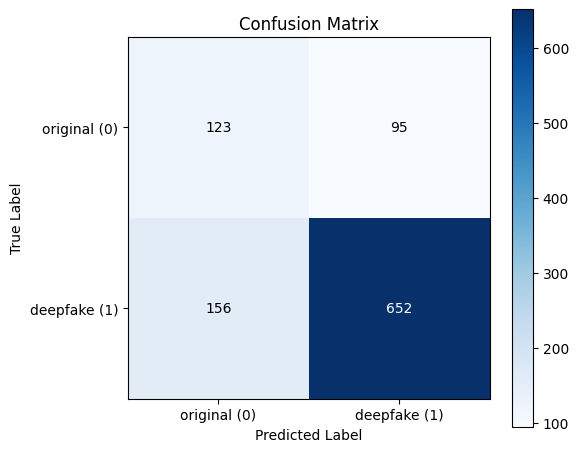

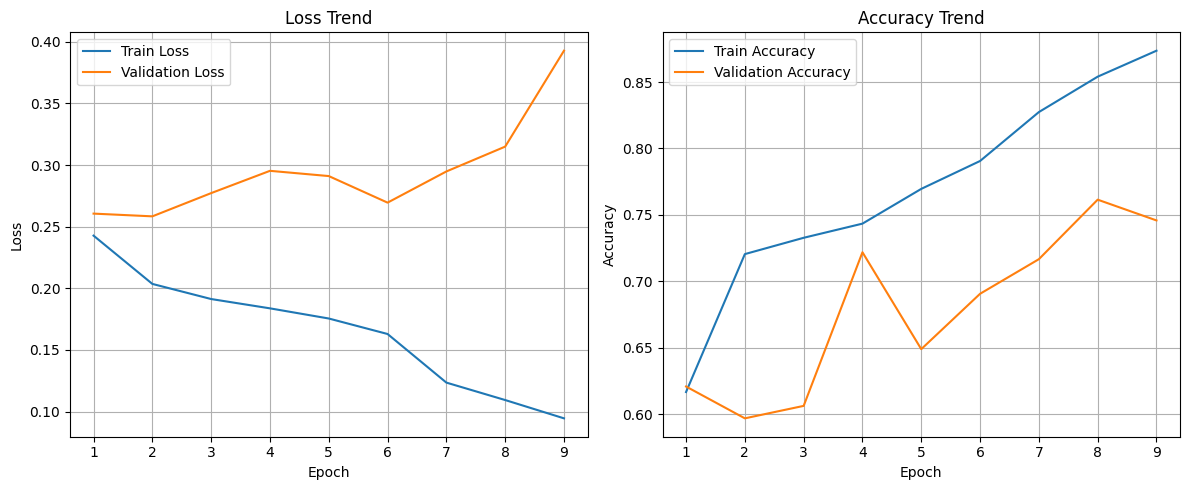

In [53]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import torch
import torch.nn as nn
from tqdm.notebook import tqdm # for progress bar


# load the saved model weights
try:
    model.load_state_dict(torch.load('final_best_model_flow_depth_transformer.pth', map_location=device))
    print("Model loaded successfully from 'final_best_model_flow_depth_transformer.pth'")
except FileNotFoundError:
    print("Error: Model weights file not found. Please ensure training saved the model.")

model.eval() # set the model to evaluation mode

# prepare variables to accumulate predictions and labels
all_preds = []
all_labels = []

test_loss = 0.0
correct_predictions = 0
total_samples = 0

criterion = nn.BCEWithLogitsLoss()

with torch.no_grad():
    for flows, depths, labels in tqdm(test_loader, desc="Evaluating on test set"):
        flows  = flows.to(device)
        depths = depths.to(device)
        labels = labels.to(device)

        # get model outputs
        outputs = model(flows, depths).squeeze(1) 

        # calculate loss
        loss = criterion(outputs, labels)
        test_loss += loss.item() * flows.size(0) 

        # get binary predictions by applying sigmoid and thresholding at 0.5
        preds = (torch.sigmoid(outputs) > 0.5).float()

        # store predictions and true labels (move to CPU and convert to NumPy arrays)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        # accumulate correct predictions and total samples for overall accuracy
        correct_predictions += (preds == labels).sum().item()
        total_samples += labels.size(0)

# calculate evaluation metrics
avg_test_loss    = test_loss / total_samples
test_accuracy    = correct_predictions / total_samples
precision        = precision_score(all_labels, all_preds)
recall           = recall_score(all_labels, all_preds)
f1               = f1_score(all_labels, all_preds)
conf_mat         = confusion_matrix(all_labels, all_preds)

# print the calculated metrics
print(f"\n--- Evaluation Results ---")
print(f"Average Test Loss: {avg_test_loss:.4f}")
print(f"Accuracy:          {test_accuracy:.4f}")
print(f"Precision:         {precision:.4f}")
print(f"Recall:            {recall:.4f}")
print(f"F1-score:          {f1:.4f}")

# plot the confusion matrix using pure matplotlib
plt.figure(figsize=(6, 5)) 
plt.imshow(conf_mat, interpolation='nearest', cmap=plt.cm.Blues)
plt.title("Confusion Matrix") 
plt.colorbar() 
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['original (0)', 'deepfake (1)'])
plt.yticks(tick_marks, ['original (0)', 'deepfake (1)']) 
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

thresh = conf_mat.max() / 2. 
for i in range(conf_mat.shape[0]):
    for j in range(conf_mat.shape[1]):
        plt.text(j, i, format(conf_mat[i, j], 'd'),
                 ha="center", va="center", 
                 color="white" if conf_mat[i, j] > thresh else "black") 

plt.tight_layout()
plt.show() 

# plot training/validation curves 
try:
    epochs = range(1, len(training_losses) + 1)
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))

    # Plot Loss curves
    axes[0].plot(epochs, training_losses,     label='Train Loss')
    axes[0].plot(epochs, validation_losses,   label='Validation Loss')
    axes[0].set_xlabel('Epoch')
    axes[0].set_ylabel('Loss')
    axes[0].set_title('Loss Trend')
    axes[0].legend()
    axes[0].grid(True) 

    # plot Accuracy curves
    axes[1].plot(epochs, training_accuracies, label='Train Accuracy')
    axes[1].plot(epochs, validation_accuracies, label='Validation Accuracy')
    axes[1].set_xlabel('Epoch')
    axes[1].set_ylabel('Accuracy')
    axes[1].set_title('Accuracy Trend')
    axes[1].legend()
    axes[1].grid(True) 

    plt.tight_layout() 
    plt.show() 

except NameError:
    print("\nWarning: Could not find training_losses/validation_losses/training_accuracies/validation_accuracies lists.")
    print("Please ensure you populate these lists during training to plot the curves.")


In [34]:
device = torch.device('cpu')
model.to(device)
flow_batch = flow_batch.to(device)
depth_batch = depth_batch.to(device)


In [35]:
model.qconfig = torch.quantization.get_default_qconfig('fbgemm')
torch.quantization.prepare(model, inplace=True)

model.eval()
device = torch.device('cpu')
model.to(device)

with torch.no_grad():
    for flow_batch, depth_batch in calibration_dataloader:
        flow_batch = flow_batch.to(device).float()
        depth_batch = depth_batch.to(device).float()
        model(flow_batch, depth_batch)  # only forward pass for calibration

torch.quantization.convert(model, inplace=True)


FlowBasedDeepfakeDetectorWithTransformer(
  (flow_feature_extractor): FlowFeatureExtractor(
    (resnet_conv1): QuantizedConv2d(2, 64, kernel_size=(7, 7), stride=(2, 2), scale=0.15149588882923126, zero_point=58, padding=(3, 3), bias=False)
    (resnet_layers): Sequential(
      (0): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (3): Sequential(
        (0): BasicBlock(
          (conv1): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.07745133340358734, zero_point=86, padding=(1, 1), bias=False)
          (bn1): QuantizedBatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplace=True)
          (conv2): QuantizedConv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), scale=0.02830119989812374, zero_point=71, padding=(1, 1), bias=False)
          (bn2): Quantiz

In [47]:
model.eval()
correct = 0
total = 0

with torch.no_grad():
    for flow_batch, depth_batch, labels in test_loader: # Changed test_dataloader to test_loader
        flow_batch = flow_batch.to(device).float()
        depth_batch = depth_batch.to(device).float()
        labels = labels.to(device)

        outputs = model(flow_batch, depth_batch)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = correct / total
print(f"Accuracy modello quantizzato: {accuracy:.4f}")

NotImplementedError: Could not run 'aten::add.out' with arguments from the 'QuantizedCPU' backend. This could be because the operator doesn't exist for this backend, or was omitted during the selective/custom build process (if using custom build). If you are a Facebook employee using PyTorch on mobile, please visit https://fburl.com/ptmfixes for possible resolutions. 'aten::add.out' is only available for these backends: [CPU, CUDA, Meta, MkldnnCPU, SparseCPU, SparseCUDA, SparseMeta, SparseCsrCPU, SparseCsrCUDA, SparseCsrMeta, BackendSelect, Python, FuncTorchDynamicLayerBackMode, Functionalize, Named, Conjugate, Negative, ZeroTensor, ADInplaceOrView, AutogradOther, AutogradCPU, AutogradCUDA, AutogradHIP, AutogradXLA, AutogradMPS, AutogradIPU, AutogradXPU, AutogradHPU, AutogradVE, AutogradLazy, AutogradMTIA, AutogradPrivateUse1, AutogradPrivateUse2, AutogradPrivateUse3, AutogradMeta, AutogradNestedTensor, Tracer, AutocastCPU, AutocastXPU, AutocastMPS, AutocastCUDA, FuncTorchBatched, BatchedNestedTensor, FuncTorchVmapMode, Batched, VmapMode, FuncTorchGradWrapper, PythonTLSSnapshot, FuncTorchDynamicLayerFrontMode, PreDispatch, PythonDispatcher].

CPU: registered at /pytorch/build/aten/src/ATen/RegisterCPU.cpp:30477 [kernel]
CUDA: registered at /pytorch/build/aten/src/ATen/RegisterCUDA.cpp:44731 [kernel]
Meta: registered at /dev/null:241 [kernel]
MkldnnCPU: registered at /pytorch/build/aten/src/ATen/RegisterMkldnnCPU.cpp:535 [kernel]
SparseCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCPU.cpp:1407 [kernel]
SparseCUDA: registered at /pytorch/build/aten/src/ATen/RegisterSparseCUDA.cpp:1577 [kernel]
SparseMeta: registered at /pytorch/build/aten/src/ATen/RegisterSparseMeta.cpp:291 [kernel]
SparseCsrCPU: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrCPU.cpp:1155 [kernel]
SparseCsrCUDA: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrCUDA.cpp:1291 [kernel]
SparseCsrMeta: registered at /pytorch/build/aten/src/ATen/RegisterSparseCsrMeta.cpp:1069 [kernel]
BackendSelect: fallthrough registered at /pytorch/aten/src/ATen/core/BackendSelectFallbackKernel.cpp:3 [backend fallback]
Python: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:194 [backend fallback]
FuncTorchDynamicLayerBackMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:503 [backend fallback]
Functionalize: registered at /pytorch/build/aten/src/ATen/RegisterFunctionalization_0.cpp:23301 [kernel]
Named: fallthrough registered at /pytorch/aten/src/ATen/core/NamedRegistrations.cpp:11 [kernel]
Conjugate: registered at /pytorch/aten/src/ATen/ConjugateFallback.cpp:17 [backend fallback]
Negative: registered at /pytorch/aten/src/ATen/native/NegateFallback.cpp:18 [backend fallback]
ZeroTensor: registered at /pytorch/aten/src/ATen/ZeroTensorFallback.cpp:86 [backend fallback]
ADInplaceOrView: registered at /pytorch/torch/csrc/autograd/generated/ADInplaceOrViewType_0.cpp:4942 [kernel]
AutogradOther: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradCUDA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHIP: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXLA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMPS: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradIPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradXPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradHPU: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradVE: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradLazy: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMTIA: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse1: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse2: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradPrivateUse3: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradMeta: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
AutogradNestedTensor: registered at /pytorch/torch/csrc/autograd/generated/VariableType_4.cpp:19365 [autograd kernel]
Tracer: registered at /pytorch/torch/csrc/autograd/generated/TraceType_2.cpp:17801 [kernel]
AutocastCPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:322 [backend fallback]
AutocastXPU: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:465 [backend fallback]
AutocastMPS: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:209 [backend fallback]
AutocastCUDA: fallthrough registered at /pytorch/aten/src/ATen/autocast_mode.cpp:165 [backend fallback]
FuncTorchBatched: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:731 [backend fallback]
BatchedNestedTensor: registered at /pytorch/aten/src/ATen/functorch/LegacyBatchingRegistrations.cpp:758 [backend fallback]
FuncTorchVmapMode: fallthrough registered at /pytorch/aten/src/ATen/functorch/VmapModeRegistrations.cpp:27 [backend fallback]
Batched: registered at /pytorch/aten/src/ATen/LegacyBatchingRegistrations.cpp:1075 [backend fallback]
VmapMode: fallthrough registered at /pytorch/aten/src/ATen/VmapModeRegistrations.cpp:33 [backend fallback]
FuncTorchGradWrapper: registered at /pytorch/aten/src/ATen/functorch/TensorWrapper.cpp:207 [backend fallback]
PythonTLSSnapshot: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:202 [backend fallback]
FuncTorchDynamicLayerFrontMode: registered at /pytorch/aten/src/ATen/functorch/DynamicLayer.cpp:499 [backend fallback]
PreDispatch: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:206 [backend fallback]
PythonDispatcher: registered at /pytorch/aten/src/ATen/core/PythonFallbackKernel.cpp:198 [backend fallback]
